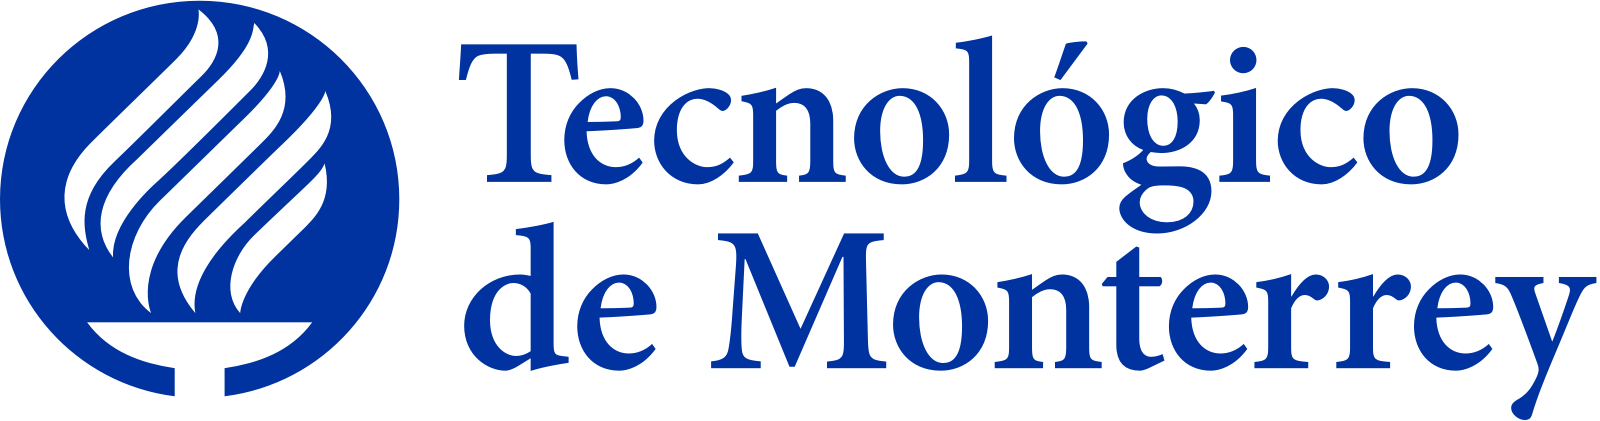

---
# Instituto Tecnológico y de Estudios Superiores de Monterrey


## **Capstone Project (Team #49)**


### **Stage 2.** Feature Engineering


#### *Author:* Julia Gabriela Pinedo -- A01795315

#### *Professor:* Dr. Grettel Barceló Alonso
#### *Project Advisor:* Dr. Guillermo Mota Medina

---

## Table of Contents
1. [Introduction](#introduction)
2. [Background](#background)
3. [Feature Engineering](#fe)
4. [Conclusion](#conclusion)
5. [References](#references)

---

### *--Conclusion from EDA Notebook--*

*In conclusion, the EDA has shown that:*

- *The percentage of missing values is low, but this suggests that there are issues with the artifacts generated from the simulation.*
- *The robot frequently operates at intermediate distances to the goal. The outliers identified in IMU readings and velocities reflect unusual events such as collisions or stalls.*
- *The categorical variables reflect that most episodes failed to reach the goal, and box or wall interactions occurred in a minority of cases.*
- *The skewness shown in several variables is consistent with the task difficulty, suggesting that reward shaping and state normalization are relevant for RL training.*
- *The bivariate analysis reinforces that success is associated with shorter distances to the goal and more consistent navigation.*
- *The analysis of the class balance provides a useful baseline to evaluate progress during RL training.*

*The EDA confirms that the dataset captures the essential dynamics of the simulated tasks, guiding the definition of the state representation and the evaluation of the A2C and PPO algorithms.*

---

# Introduction <a class="anchor" id="introduction" ></a>

To initiate the exploratory analysis of our Reinforcement Learning environment, a synthetic dataset was generated directly from the Gazebo simulation of the box-pushing scenario (**Figure 1**).

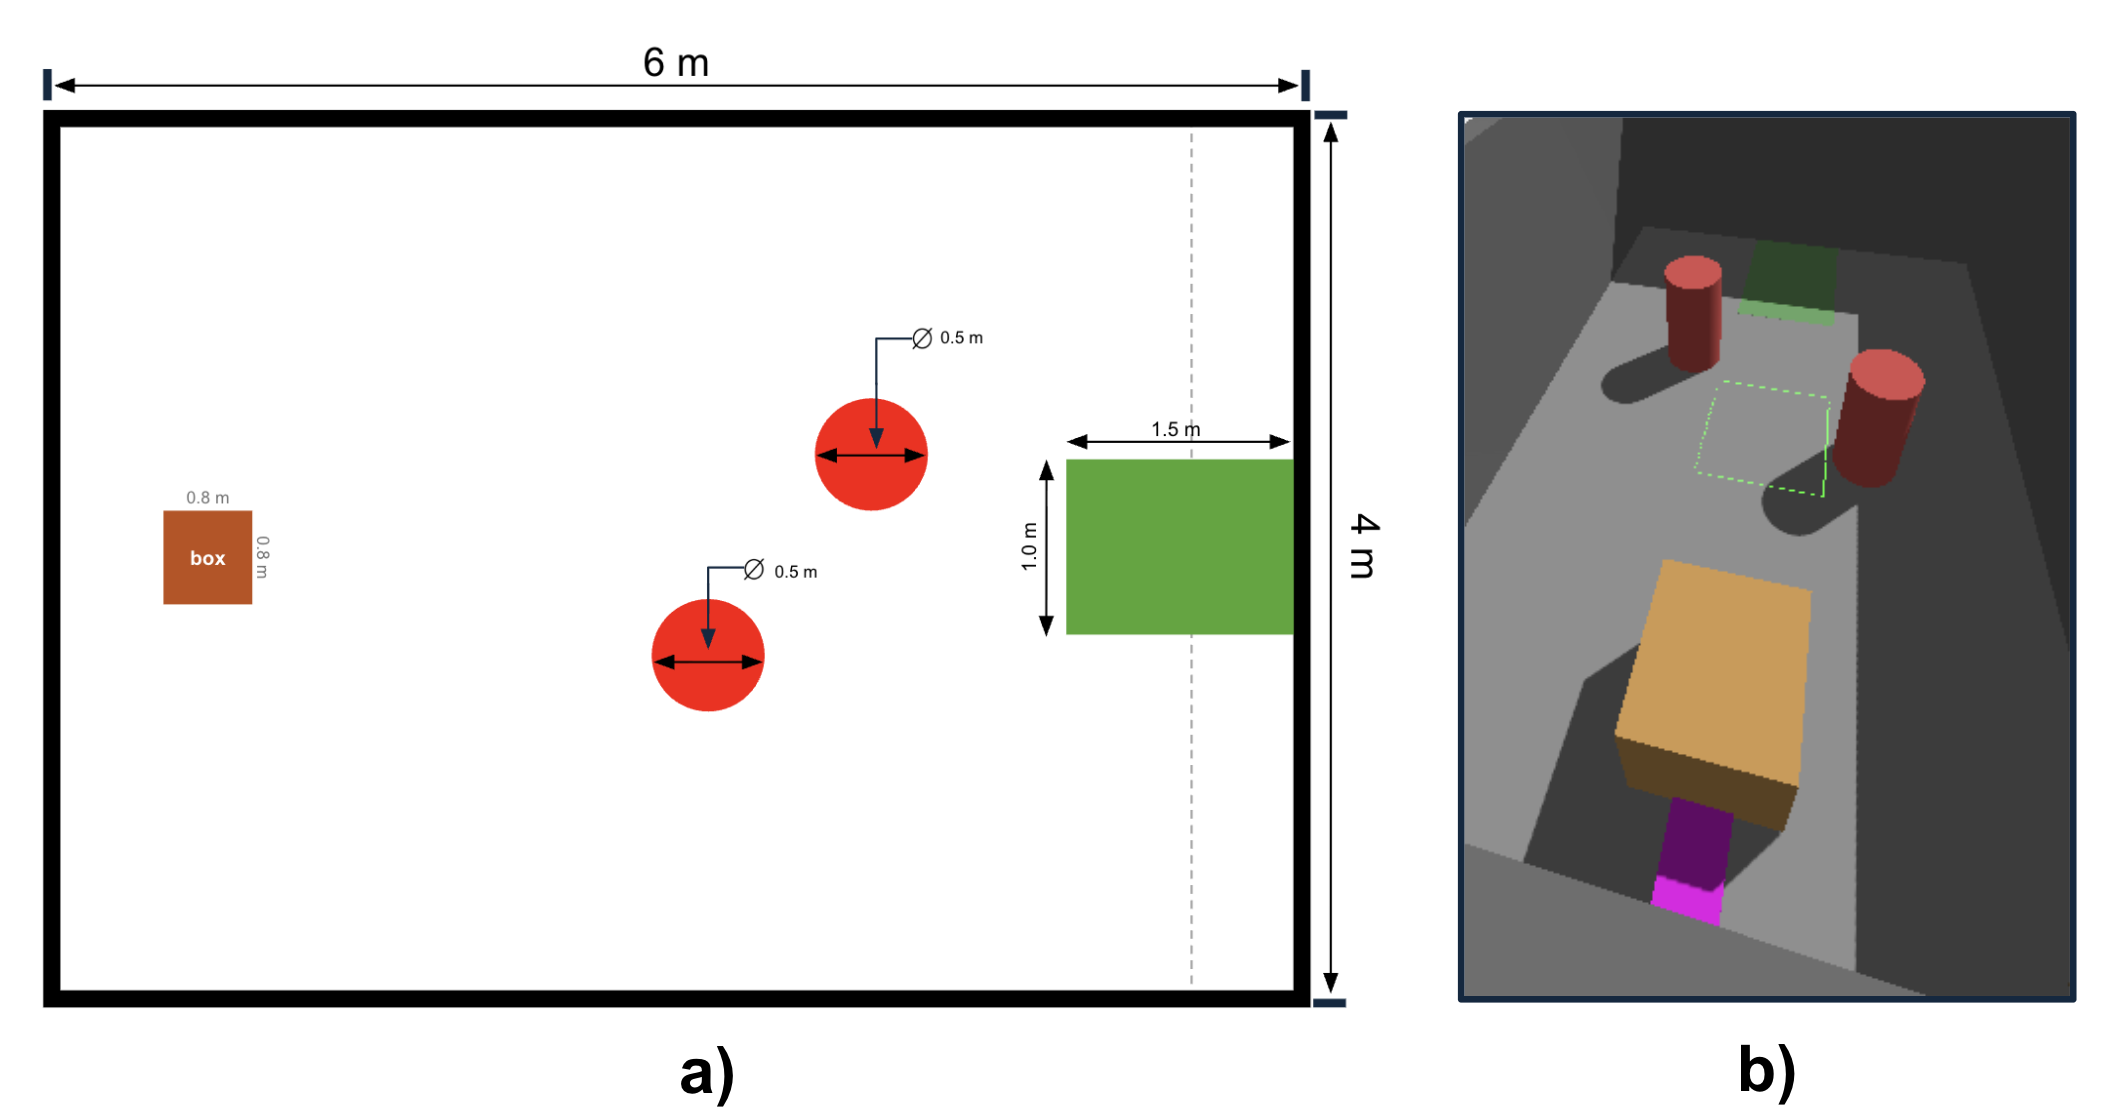
**Figure 1.** Simulation environment. a) Diagram of the arena, b) Arena modeled and simulated in Gazebo.

As stated in **Stage 1** of the project, the diagnostic sample let us understand that:
- The collected information had missing values, related to issues with the artifacts generated from the simulations.
- The robot failed to push the box due to its unrealistic setup.
- The cylindrical obstacles were often too far away to be able to learn how to avoid them.

Due to this, the following solutions were determined:

1. **Goal-driven spawn geometry.** We start the robot and the box at fixed coordinates of **(-2.7, 0.0, 0.00)** and **(-2.0, 0.0, 0.40)**, respectively. This creates a straight, line-of-sight approach; long enough to let the closed-loop velocity/IMU estimates stabilize before contact and avoid immediate collision impulses at spawn. This is helpful for later training on the A2C and PPO models, as it reduces noise. Additionally, the obstacle positions were adjusted to maintain a clear corridor ahead of the box and to prevent grazing contacts with walls that could confound reward shaping.

2. **Curriculum design**. The box is now **0.8 x 0.8 x 0.8 m** with a mass of **m = 7.5 kg**. Early episodes emphasize perception, alignment, and contact stability over sheer traction. For the planned **two-agent phase**, the same corridor is what lets us introduce cooperative side-by-side pushes without re-authoring the map.

3. **Telemetry robustness**. Pose publisher systems were included for both the box and the robot. The publishers operate at **30-60 Hz** with model and link frames enabled, eliminating transient nulls at spawn and ensuring time-consistent world/pose streams. Contact sensors were attached directly to the active collision primitives to suppress micro-contacts during settling. These changes reduced observation noise and null pose values.

# Background <a class="anchor" id="background" ></a>

## Global Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from math import ceil
from sklearn.linear_model import RidgeCV

## Importing the Dataset

In [2]:
df = pd.read_csv('out.csv')
df

,episode,step,done,done_reason,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,...,cmd_wz,wheel_l_rad_s,wheel_r_rad_s,r_progress,r_collision,r_efficiency,r_rot_pen,r_goal,r_total,in_goal
0,1,1,False,timeout,-2.620000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.000000,10.000000,10.000000,0.000000,0.0,0.0,-0.000000,0.0,0.000000,False
1,1,2,False,timeout,-2.540000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.000000,10.000000,10.000000,0.000000,0.0,0.0,-0.000000,0.0,0.000000,False
2,1,3,False,timeout,-2.460000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.000000,10.000000,10.000000,0.000000,0.0,0.0,-0.000000,0.0,0.000000,False
3,1,4,False,timeout,-2.380000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.000000,10.000000,10.000000,0.000000,0.0,0.0,-0.000000,0.0,0.000000,False
4,1,5,False,timeout,-2.300000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.000000,10.000000,10.000000,0.000000,0.0,0.0,-0.000000,0.0,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,10,46,False,timeout,0.979988,-0.007436,-0.002701,0.8,0.0,0.002642,...,0.002642,9.994551,10.005449,0.079997,0.0,0.0,-0.000003,0.0,0.079994,False
496,10,47,False,timeout,1.059987,-0.007652,-0.002375,0.8,0.0,0.003258,...,0.003258,9.993281,10.006719,0.080001,0.0,0.0,-0.000003,0.0,0.079998,False
497,10,48,False,timeout,1.139987,-0.007842,-0.002079,0.8,0.0,0.002956,...,0.002956,9.993904,10.006096,0.079998,0.0,0.0,-0.000003,0.0,0.079995,False
498,10,49,False,timeout,1.219987,-0.008009,-0.001764,0.8,0.0,0.003159,...,0.003159,9.993485,10.006515,0.079999,0.0,0.0,-0.000003,0.0,0.079995,False


In the initial dataset, variables were logged at different rates and directly from ROS topics. This produced asynchronous entries and missing values in key state variables such as position, velocity, and contact indicators. To address these limitations, the telemetry pipeline was redesigned with synchronized logging and structured interfaces for both the robot and the box. This new data acquisition layer uses the **Pose Publisher** and **Contact Sensor Systems** (as mentioned in the **Introduction**), ensuring that all relevant signals are published at consistent frequencies and without delays at spawn or contact events, making the dataset semantically aligned with the **RL paradigm**.

Another important thing to point out is that the `episode_success` variable was not included. This approach is not conceptually valid in Reinforcement Learning, as RL does not use a predefined output label to train the model. Instead, the agent learns through interaction with the environment, guided by **rewards** rather than fixed success/failure labels. 

Let's take a look at the structure of our dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   episode        500 non-null    int64  
 1   step           500 non-null    int64  
 2   done           500 non-null    bool   
 3   done_reason    500 non-null    object 
 4   robot_x        500 non-null    float64
 5   robot_y        500 non-null    float64
 6   robot_yaw      500 non-null    float64
 7   robot_vx       500 non-null    float64
 8   robot_vy       500 non-null    float64
 9   robot_wz       500 non-null    float64
 10  imu_wx         500 non-null    float64
 11  imu_wy         500 non-null    float64
 12  imu_wz         500 non-null    float64
 13  imu_ax         500 non-null    float64
 14  imu_ay         500 non-null    float64
 15  imu_az         500 non-null    float64
 16  box_x          500 non-null    float64
 17  box_y          500 non-null    float64
 18  box_yaw   

We observe that:

- We generated **500 synchronized steps**, ensuring full observability per step. This is ideal for the **state-action-reward** separation in later phases.

- The variable naming includes **explicit prefixes**, improving clarity between robot state, control commands, and box states.

- Included **boolean** variables to avoid ambiguous partial contact magnitudes.

- Included **reward signals**, which are the components explicitly logged for training and evaluation, enabling immediate state-reward association.

- Introduced unified logging to collect all variables per step before writing, which **removed null values** due to unsynchronized ROS topics.

Let's divide the dataset into three logical subsets representing the canonical components of the RL formalism:

- **State**: Contains the robot's sensory and positional data as well as environmental information.
- **Action**: Includes the commanded velocities and wheel rotational speeds that define the agent's behavior.
- **Reward**: Encapsulates the stepwise feedback that guides learning.

### State DataFrame

In [4]:
# State columns
state_cols = [
    'episode', 'step', 'done', 'done_reason',
    # Robot kinematics
    'robot_x', 'robot_y', 'robot_yaw',
    'robot_vx', 'robot_vy', 'robot_wz',
    # IMU readings
    'imu_wx', 'imu_wy', 'imu_wz',
    'imu_ax', 'imu_ay', 'imu_az',
    # Box and goal positions
    'box_x', 'box_y', 'box_yaw',
    'goal_x', 'goal_y',
    # Binary states
    'contact_flag', 'in_goal'
]

state_df = df[state_cols].copy()
state_df

,episode,step,done,done_reason,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,...,imu_ax,imu_ay,imu_az,box_x,box_y,box_yaw,goal_x,goal_y,contact_flag,in_goal
0,1,1,False,timeout,-2.620000,0.000000,0.000000,0.8,0.0,-0.000000,...,0.005975,-0.005483,9.801094,-2.00,0.000000,0.0,2.25,0.0,False,False
1,1,2,False,timeout,-2.540000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.019833,0.001203,9.823402,-2.00,0.000000,0.0,2.25,0.0,False,False
2,1,3,False,timeout,-2.460000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.012409,0.009797,9.813569,-2.00,0.000000,0.0,2.25,0.0,False,False
3,1,4,False,timeout,-2.380000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.018609,-0.000585,9.816953,-2.00,0.000000,0.0,2.25,0.0,False,False
4,1,5,False,timeout,-2.300000,0.000000,0.000000,0.8,0.0,-0.000000,...,-0.009152,-0.038024,9.797105,-2.00,0.000000,0.0,2.25,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,10,46,False,timeout,0.979988,-0.007436,-0.002701,0.8,0.0,0.002642,...,0.049635,-0.006049,9.813367,1.28,-0.004072,0.0,2.25,0.0,True,False
496,10,47,False,timeout,1.059987,-0.007652,-0.002375,0.8,0.0,0.003258,...,0.002477,-0.014130,9.823847,1.36,-0.003695,0.0,2.25,0.0,True,False
497,10,48,False,timeout,1.139987,-0.007842,-0.002079,0.8,0.0,0.002956,...,-0.004370,0.003331,9.804401,1.44,-0.003949,0.0,2.25,0.0,True,False
498,10,49,False,timeout,1.219987,-0.008009,-0.001764,0.8,0.0,0.003159,...,-0.004505,0.015513,9.829692,1.52,-0.004001,0.0,2.25,0.0,True,False


In [5]:
# Let's make sure that we still don't have any Null values:
missing_val = state_df.isna().sum()
missing_percentage = missing_val * 100 / len(state_df)

# Print the dataframe containing the percentage of missing values
df_missing = pd.DataFrame({
    'Column': state_df.columns,
    'Missing Values (%)': missing_percentage.astype(str) + '%' 
})
print(tabulate(df_missing, headers='keys', tablefmt='psql', showindex=False))

+--------------+----------------------+
| Column       | Missing Values (%)   |
|--------------+----------------------|
| episode      | 0.0%                 |
| step         | 0.0%                 |
| done         | 0.0%                 |
| done_reason  | 0.0%                 |
| robot_x      | 0.0%                 |
| robot_y      | 0.0%                 |
| robot_yaw    | 0.0%                 |
| robot_vx     | 0.0%                 |
| robot_vy     | 0.0%                 |
| robot_wz     | 0.0%                 |
| imu_wx       | 0.0%                 |
| imu_wy       | 0.0%                 |
| imu_wz       | 0.0%                 |
| imu_ax       | 0.0%                 |
| imu_ay       | 0.0%                 |
| imu_az       | 0.0%                 |
| box_x        | 0.0%                 |
| box_y        | 0.0%                 |
| box_yaw      | 0.0%                 |
| goal_x       | 0.0%                 |
| goal_y       | 0.0%                 |
| contact_flag | 0.0%                 |


Since the `episode`, `step`, `done`, and `done_reason` columns were retained only for diagnostic purposes (*they represent metadata rather than observable environment states*), let's safely exclude them.

In [6]:
state_df = state_df.drop(columns=['episode', 'step', 'done', 'done_reason'])
state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,imu_wx,imu_wy,imu_wz,imu_ax,imu_ay,imu_az,box_x,box_y,box_yaw,goal_x,goal_y,contact_flag,in_goal
0,-2.620000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.000012,0.005975,-0.005483,9.801094,-2.00,0.000000,0.0,2.25,0.0,False,False
1,-2.540000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004547,-0.019833,0.001203,9.823402,-2.00,0.000000,0.0,2.25,0.0,False,False
2,-2.460000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004922,-0.012409,0.009797,9.813569,-2.00,0.000000,0.0,2.25,0.0,False,False
3,-2.380000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.001054,-0.018609,-0.000585,9.816953,-2.00,0.000000,0.0,2.25,0.0,False,False
4,-2.300000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.013442,-0.009152,-0.038024,9.797105,-2.00,0.000000,0.0,2.25,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.979988,-0.007436,-0.002701,0.8,0.0,0.002642,0.0,0.0,0.008068,0.049635,-0.006049,9.813367,1.28,-0.004072,0.0,2.25,0.0,True,False
496,1.059987,-0.007652,-0.002375,0.8,0.0,0.003258,0.0,0.0,-0.022407,0.002477,-0.014130,9.823847,1.36,-0.003695,0.0,2.25,0.0,True,False
497,1.139987,-0.007842,-0.002079,0.8,0.0,0.002956,0.0,0.0,-0.004820,-0.004370,0.003331,9.804401,1.44,-0.003949,0.0,2.25,0.0,True,False
498,1.219987,-0.008009,-0.001764,0.8,0.0,0.003159,0.0,0.0,-0.010383,-0.004505,0.015513,9.829692,1.52,-0.004001,0.0,2.25,0.0,True,False


In [7]:
# Let's make sure the "contact_flag" and "in_goal" booleans are categorical

# Cast boolean-like columns to categorical

bool_cols = ["in_goal", "contact_flag"]

# Cast to pandas 'category' dtype (keeps 0/1 values as categories; preserves NaN if present)
for c in bool_cols:
    state_df[c] = state_df[c].astype("bool").astype("category")

state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,imu_wx,imu_wy,imu_wz,imu_ax,imu_ay,imu_az,box_x,box_y,box_yaw,goal_x,goal_y,contact_flag,in_goal
0,-2.620000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.000012,0.005975,-0.005483,9.801094,-2.00,0.000000,0.0,2.25,0.0,False,False
1,-2.540000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004547,-0.019833,0.001203,9.823402,-2.00,0.000000,0.0,2.25,0.0,False,False
2,-2.460000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004922,-0.012409,0.009797,9.813569,-2.00,0.000000,0.0,2.25,0.0,False,False
3,-2.380000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.001054,-0.018609,-0.000585,9.816953,-2.00,0.000000,0.0,2.25,0.0,False,False
4,-2.300000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.013442,-0.009152,-0.038024,9.797105,-2.00,0.000000,0.0,2.25,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.979988,-0.007436,-0.002701,0.8,0.0,0.002642,0.0,0.0,0.008068,0.049635,-0.006049,9.813367,1.28,-0.004072,0.0,2.25,0.0,True,False
496,1.059987,-0.007652,-0.002375,0.8,0.0,0.003258,0.0,0.0,-0.022407,0.002477,-0.014130,9.823847,1.36,-0.003695,0.0,2.25,0.0,True,False
497,1.139987,-0.007842,-0.002079,0.8,0.0,0.002956,0.0,0.0,-0.004820,-0.004370,0.003331,9.804401,1.44,-0.003949,0.0,2.25,0.0,True,False
498,1.219987,-0.008009,-0.001764,0.8,0.0,0.003159,0.0,0.0,-0.010383,-0.004505,0.015513,9.829692,1.52,-0.004001,0.0,2.25,0.0,True,False


In [8]:
# Let's obtain a small summary of the Numerical and Categorical variables

# Use the "describe" function to obtain a summary of statistics for all variables
statistics_description = state_df.describe()

# Create custom names to hold the values previously obtained
custom_names = {
    'mean': 'mean',
    'std': 'std',
    '25%': '25%',
    '50%': '50%',
    '75%': '75%',
}

# Rename the rows with the custom names
statistics_description.rename(index=custom_names, inplace=True)
statistics_description.loc['median'] = statistics_description.loc['50%']

# *********************** PART 1: Shape measures (skewness and kurtosis) ***********************

# Using the "skew" function to obtain the skewness value for all variables
skewness = state_df.skew(numeric_only=True) 

# Create a dataframe from the obtained values, naming the column as skewness
skewness_df = pd.DataFrame({'skewness': skewness})
skewness_df = skewness_df.T

# Using the "kurtosis" function to obtain the kurtosis value for all variables
kurtosis = state_df.kurtosis(numeric_only=True)

# Create a dataframe from the obtained values, naming the column as kurtosis
kurtosis_df = pd.DataFrame({'kurtosis': kurtosis})
kurtosis_df = kurtosis_df.T

# ******************************** PART 2: Resulting DataFrame *********************************

# Concatenate the three dataframes to present a single dataframe with all information
statistics_summary = pd.concat([statistics_description,
                                skewness_df,
                                kurtosis_df], ignore_index=False)

statistics_summary.T

,count,mean,std,min,25%,50%,75%,max,median,skewness,kurtosis
robot_x,500.0,-0.660330,1.155081,-2.620000,-1.660000,-0.660005,0.339992,1.299992,-0.660005,-0.001493,-1.202776
robot_y,500.0,0.001129,0.005923,-0.011077,-0.000697,0.000000,0.001180,0.028814,0.000000,1.773221,4.511441
robot_yaw,500.0,0.001291,0.005182,-0.005919,-0.001961,0.000000,0.003179,0.021648,0.000000,1.483005,2.369384
robot_vx,500.0,0.796800,0.050546,0.000000,0.800000,0.800000,0.800000,0.800000,0.800000,-15.763692,247.483912
robot_vy,500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
robot_wz,500.0,0.000856,0.002699,-0.004879,-0.000908,-0.000000,0.002501,0.009059,-0.000000,0.797552,0.267864
imu_wx,500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
imu_wy,500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
imu_wz,500.0,0.001499,0.010869,-0.038546,-0.005651,0.001536,0.008895,0.028817,0.001536,-0.027559,0.014324
imu_ax,500.0,-0.000831,0.019890,-0.065029,-0.014429,-0.001693,0.013250,0.056578,-0.001693,-0.039818,0.075662


In [9]:
# ********************* PART 1: Print tables with unique counts per column *********************

cat_like_cols = state_df.select_dtypes(include=["category", "object"]).columns

for column in cat_like_cols:
    counts = state_df[column].value_counts(dropna=False).reset_index()
    counts.columns = [column, "Counts:"]
    
    counts[column] = counts[column].astype(object)
    counts[column] = counts[column].where(counts[column].notna(), "NaN")
    counts[column] = counts[column].astype(str)

    print(tabulate(counts, headers="keys", tablefmt="psql", showindex=False))

+----------------+-----------+
| contact_flag   |   Counts: |
|----------------+-----------|
| True           |       448 |
| False          |        52 |
+----------------+-----------+
+-----------+-----------+
| in_goal   |   Counts: |
|-----------+-----------|
| False     |       496 |
| True      |         4 |
+-----------+-----------+


#### Conclusions from EDA Notebook:

- **Standardization**: Good for variables like velocity, angular velocity, and IMU signals where we want symmetrical distributions around zero.
- **Min-Max Scaling**: Useful for the variables that provide distances.
- Ideally, we could include a `distance_to_goal` and `distance_to_box` to improve derived distance measures.
- The `contact_flag` and `in_goal` can be mapped to 0/1.

### Action DataFrame

In [10]:
# Action columns
action_cols = [
    'cmd_vx', 'cmd_wz',
    'wheel_l_rad_s', 'wheel_r_rad_s'
]

action_df = df[action_cols].copy()
action_df

,cmd_vx,cmd_wz,wheel_l_rad_s,wheel_r_rad_s
0,0.8,-0.000000,10.000000,10.000000
1,0.8,-0.000000,10.000000,10.000000
2,0.8,-0.000000,10.000000,10.000000
3,0.8,-0.000000,10.000000,10.000000
4,0.8,-0.000000,10.000000,10.000000
...,...,...,...,...
495,0.8,0.002642,9.994551,10.005449
496,0.8,0.003258,9.993281,10.006719
497,0.8,0.002956,9.993904,10.006096
498,0.8,0.003159,9.993485,10.006515


In [11]:
# Let's make sure that we still don't have any Null values:
missing_val = action_df.isna().sum()
missing_percentage = missing_val * 100 / len(action_df)

# Print the dataframe containing the percentage of missing values
df_missing = pd.DataFrame({
    'Column': action_df.columns,
    'Missing Values (%)': missing_percentage.astype(str) + '%' 
})
print(tabulate(df_missing, headers='keys', tablefmt='psql', showindex=False))

+---------------+----------------------+
| Column        | Missing Values (%)   |
|---------------+----------------------|
| cmd_vx        | 0.0%                 |
| cmd_wz        | 0.0%                 |
| wheel_l_rad_s | 0.0%                 |
| wheel_r_rad_s | 0.0%                 |
+---------------+----------------------+


In [12]:
# Let's obtain a small summary of the Numerical variables

# Use the "describe" function to obtain a summary of statistics for all variables
statistics_description = action_df.describe()

# Create custom names to hold the values previously obtained
custom_names = {
    'mean': 'mean',
    'std': 'std',
    '25%': '25%',
    '50%': '50%',
    '75%': '75%',
}

# Rename the rows with the custom names
statistics_description.rename(index=custom_names, inplace=True)
statistics_description.loc['median'] = statistics_description.loc['50%']

# *********************** PART 1: Shape measures (skewness and kurtosis) ***********************

# Using the "skew" function to obtain the skewness value for all variables
skewness = action_df.skew(numeric_only=True) 

# Create a dataframe from the obtained values, naming the column as skewness
skewness_df = pd.DataFrame({'skewness': skewness})
skewness_df = skewness_df.T

# Using the "kurtosis" function to obtain the kurtosis value for all variables
kurtosis = action_df.kurtosis(numeric_only=True)

# Create a dataframe from the obtained values, naming the column as kurtosis
kurtosis_df = pd.DataFrame({'kurtosis': kurtosis})
kurtosis_df = kurtosis_df.T

# ******************************** PART 2: Resulting DataFrame *********************************

# Concatenate the three dataframes to present a single dataframe with all information
statistics_summary = pd.concat([statistics_description,
                                skewness_df,
                                kurtosis_df], ignore_index=False)

statistics_summary.T

,count,mean,std,min,25%,50%,75%,max,median,skewness,kurtosis
cmd_vx,500.0,0.796800,0.050546,0.000000,0.800000,0.8,0.800000,0.800000,0.8,-15.763692,247.483912
cmd_wz,500.0,0.000856,0.002699,-0.004879,-0.000908,-0.0,0.002501,0.009059,-0.0,0.797552,0.267864
wheel_l_rad_s,500.0,9.958234,0.631734,0.000000,9.994794,10.0,10.001872,10.010063,10.0,-15.761842,247.445028
wheel_r_rad_s,500.0,9.961766,0.631958,0.000000,9.998070,10.0,10.005159,10.018684,10.0,-15.761843,247.445056


#### Conclusions from EDA Notebook:

- **Standardization**: Good to keep symmetry in the variables that represent any control outputs that can take both positive and negative values.

### Reward DataFrame

In [13]:
# Reward columns
reward_cols = [
    'r_progress', 'r_collision', 'r_efficiency',
    'r_rot_pen', 'r_goal', 'r_total'
]

reward_df = df[reward_cols].copy()
reward_df

,r_progress,r_collision,r_efficiency,r_rot_pen,r_goal,r_total
0,0.000000,0.0,0.0,-0.000000,0.0,0.000000
1,0.000000,0.0,0.0,-0.000000,0.0,0.000000
2,0.000000,0.0,0.0,-0.000000,0.0,0.000000
3,0.000000,0.0,0.0,-0.000000,0.0,0.000000
4,0.000000,0.0,0.0,-0.000000,0.0,0.000000
...,...,...,...,...,...,...
495,0.079997,0.0,0.0,-0.000003,0.0,0.079994
496,0.080001,0.0,0.0,-0.000003,0.0,0.079998
497,0.079998,0.0,0.0,-0.000003,0.0,0.079995
498,0.079999,0.0,0.0,-0.000003,0.0,0.079995


In [14]:
# Let's make sure that we still don't have any Null values:
missing_val = reward_df.isna().sum()
missing_percentage = missing_val * 100 / len(reward_df)

# Print the dataframe containing the percentage of missing values
df_missing = pd.DataFrame({
    'Column': reward_df.columns,
    'Missing Values (%)': missing_percentage.astype(str) + '%' 
})
print(tabulate(df_missing, headers='keys', tablefmt='psql', showindex=False))

+--------------+----------------------+
| Column       | Missing Values (%)   |
|--------------+----------------------|
| r_progress   | 0.0%                 |
| r_collision  | 0.0%                 |
| r_efficiency | 0.0%                 |
| r_rot_pen    | 0.0%                 |
| r_goal       | 0.0%                 |
| r_total      | 0.0%                 |
+--------------+----------------------+


Since **rewards** are not model inputs (they are target signals), we don't need to scale them, as this could distort the reward structure and change the learning objective. In that sense, any normalization applied to rewards is handled internally by the RL algorithm, so we are not standardizing or normalizing any reward variables before training.

The new data structure better reflects the continuous feedback process of RL. The **state** and **action** subsets will be used for the Feature Engineering section, while the **reward** subset provides the scalar feedback that drives policy optimization. No explicit "output variable" is required or appropriate under this paradigm.

# Feature Engineering <a class="anchor" id="fe" ></a>

*Since RL does not include any single output or target variable, the feature engineering techniques will be applied only to the state and action components, improving the quality and representation of the inputs used by the learning algorithm.*

## State DataFrame

### New Features

As defined in the previous section, we will add two new columns: `distance_to_goal` and `distance_to_box`. These two new columns use the Euclidean distance principle (**Equations 1 and 2**):

$
d_{\text{goal}} = \sqrt{(goal_x - robot_x)^2 + (goal_y - robot_y)^2} ... (1)
$

$
d_{\text{box}} = \sqrt{(box_x - robot_x)^2 + (box_y - robot_y)^2} ... (2)
$

Derived distance features quantify how far the robot is from the key targets (goal region and box). These measures will help the RL model simplify geometric relationships into single continuous variables, improving learning efficiency.

In [15]:
# Create the derived features

# Distance to Goal
state_df['distance_to_goal'] = np.sqrt(
    (state_df['goal_x'] - state_df['robot_x'])**2 +
    (state_df['goal_y'] - state_df['robot_y'])**2
)

# Distance to Box
state_df['distance_to_box'] = np.sqrt(
    (state_df['box_x'] - state_df['robot_x'])**2 +
    (state_df['box_y'] - state_df['robot_y'])**2
)

# Print the DataFrame
state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,imu_wx,imu_wy,imu_wz,imu_ax,...,imu_az,box_x,box_y,box_yaw,goal_x,goal_y,contact_flag,in_goal,distance_to_goal,distance_to_box
0,-2.620000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.000012,0.005975,...,9.801094,-2.00,0.000000,0.0,2.25,0.0,False,False,4.870000,0.620000
1,-2.540000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004547,-0.019833,...,9.823402,-2.00,0.000000,0.0,2.25,0.0,False,False,4.790000,0.540000
2,-2.460000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004922,-0.012409,...,9.813569,-2.00,0.000000,0.0,2.25,0.0,False,False,4.710000,0.460000
3,-2.380000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.001054,-0.018609,...,9.816953,-2.00,0.000000,0.0,2.25,0.0,False,False,4.630000,0.380000
4,-2.300000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.013442,-0.009152,...,9.797105,-2.00,0.000000,0.0,2.25,0.0,False,False,4.550000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.979988,-0.007436,-0.002701,0.8,0.0,0.002642,0.0,0.0,0.008068,0.049635,...,9.813367,1.28,-0.004072,0.0,2.25,0.0,True,False,1.270034,0.300031
496,1.059987,-0.007652,-0.002375,0.8,0.0,0.003258,0.0,0.0,-0.022407,0.002477,...,9.823847,1.36,-0.003695,0.0,2.25,0.0,True,False,1.190037,0.300039
497,1.139987,-0.007842,-0.002079,0.8,0.0,0.002956,0.0,0.0,-0.004820,-0.004370,...,9.804401,1.44,-0.003949,0.0,2.25,0.0,True,False,1.110041,0.300038
498,1.219987,-0.008009,-0.001764,0.8,0.0,0.003159,0.0,0.0,-0.010383,-0.004505,...,9.829692,1.52,-0.004001,0.0,2.25,0.0,True,False,1.030044,0.300040


### Encoding

The `contact_flag` and `in_goal` binary flags will be encoded as:

- 1 for True
- 0 for False

To ensure numeric consistency with the model's input format. These variables won't be standardized or scaled, since their binary nature already carries discrete meaning.

In [16]:
# Map the booleans explicitly and mark as "categorical"
state_df['contact_flag'] = state_df['contact_flag'].map({True: 1, False: 0}).astype('category')
state_df['in_goal'] = state_df['in_goal'].map({True: 1, False: 0}).astype('category')

# Print the state_df
state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,imu_wx,imu_wy,imu_wz,imu_ax,...,imu_az,box_x,box_y,box_yaw,goal_x,goal_y,contact_flag,in_goal,distance_to_goal,distance_to_box
0,-2.620000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.000012,0.005975,...,9.801094,-2.00,0.000000,0.0,2.25,0.0,0,0,4.870000,0.620000
1,-2.540000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004547,-0.019833,...,9.823402,-2.00,0.000000,0.0,2.25,0.0,0,0,4.790000,0.540000
2,-2.460000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.004922,-0.012409,...,9.813569,-2.00,0.000000,0.0,2.25,0.0,0,0,4.710000,0.460000
3,-2.380000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,0.001054,-0.018609,...,9.816953,-2.00,0.000000,0.0,2.25,0.0,0,0,4.630000,0.380000
4,-2.300000,0.000000,0.000000,0.8,0.0,-0.000000,0.0,0.0,-0.013442,-0.009152,...,9.797105,-2.00,0.000000,0.0,2.25,0.0,0,0,4.550000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.979988,-0.007436,-0.002701,0.8,0.0,0.002642,0.0,0.0,0.008068,0.049635,...,9.813367,1.28,-0.004072,0.0,2.25,0.0,1,0,1.270034,0.300031
496,1.059987,-0.007652,-0.002375,0.8,0.0,0.003258,0.0,0.0,-0.022407,0.002477,...,9.823847,1.36,-0.003695,0.0,2.25,0.0,1,0,1.190037,0.300039
497,1.139987,-0.007842,-0.002079,0.8,0.0,0.002956,0.0,0.0,-0.004820,-0.004370,...,9.804401,1.44,-0.003949,0.0,2.25,0.0,1,0,1.110041,0.300038
498,1.219987,-0.008009,-0.001764,0.8,0.0,0.003159,0.0,0.0,-0.010383,-0.004505,...,9.829692,1.52,-0.004001,0.0,2.25,0.0,1,0,1.030044,0.300040


In [17]:
# Make sure the variables are categorical
print(state_df[['contact_flag', 'in_goal']].dtypes)

contact_flag    category
in_goal         category
dtype: object


### Scaling

To determine the most appropriate scaling strategy for each continuous variable, Q-Q (quantile-quantile) plots will be generated.

In [18]:
# Generate Q-Q plot

def create_QQ_graph_for_each_column(df, column_name):
    plt.figure(figsize=(10, 7))
    stats.probplot(df[column_name], plot=plt, dist='norm')
    plt.title(f'Q-Q plot for the column: {column_name}')
    plt.show()

# Print histograms
def hist_grid(df, columns=None, ncols=4, bins=20, figsize=(14, 8)):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns.tolist()
    # Avoid plotting categorical columns
    columns = [c for c in columns if c not in ['contact_flag','in_goal']]
    if not columns:
        print("No columns to plot."); return

    nrows = ceil(len(columns) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1) 

    for ax, col in zip(axes, columns):
        df[col].hist(ax=ax, bins=bins)
        ax.set_title(col, fontsize=9)
        ax.tick_params(axis='both', labelsize=8)
    # Hide extra axes
    for ax in axes[len(columns):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

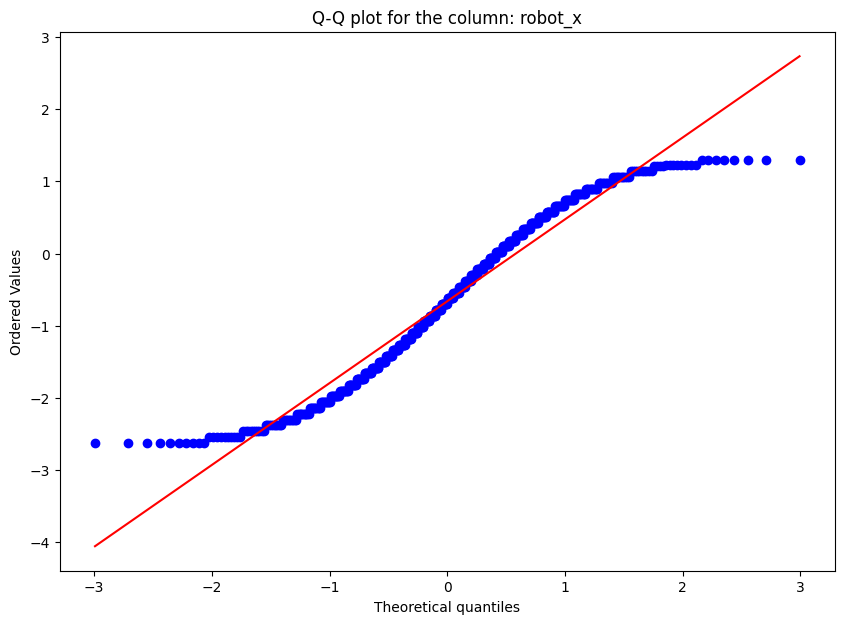

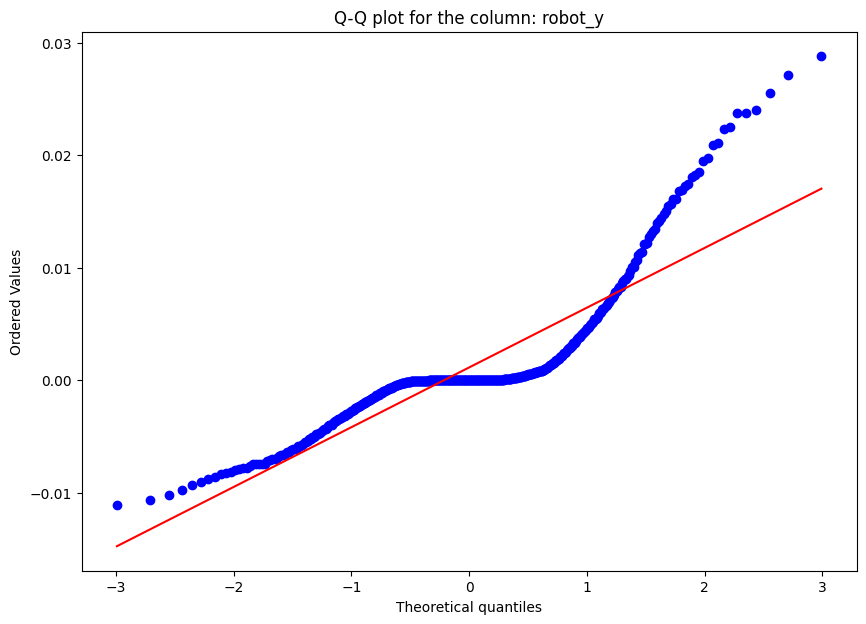

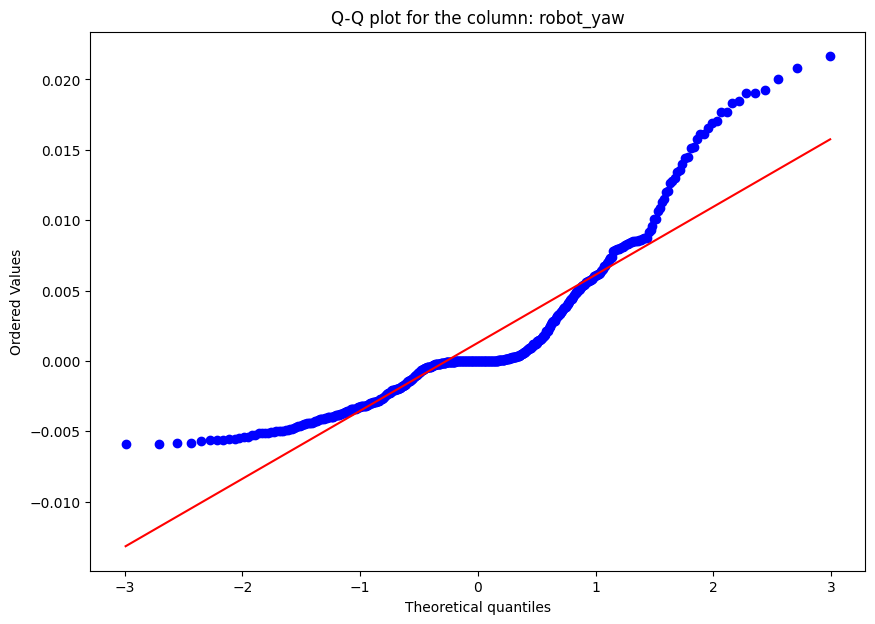

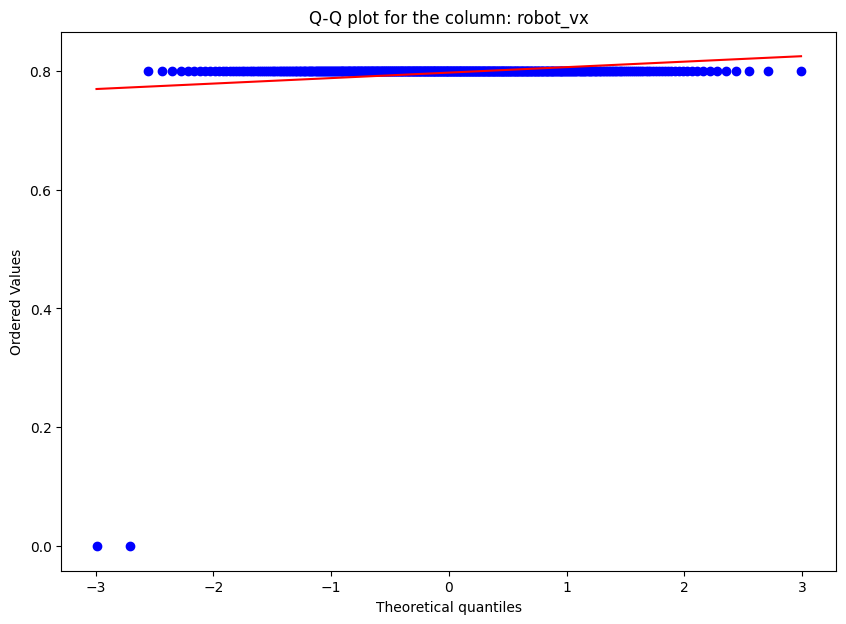

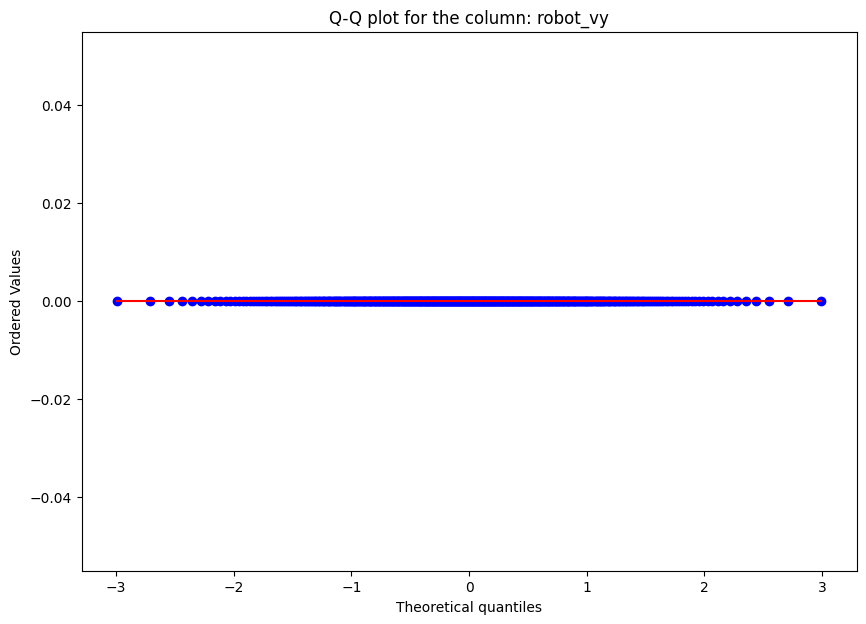

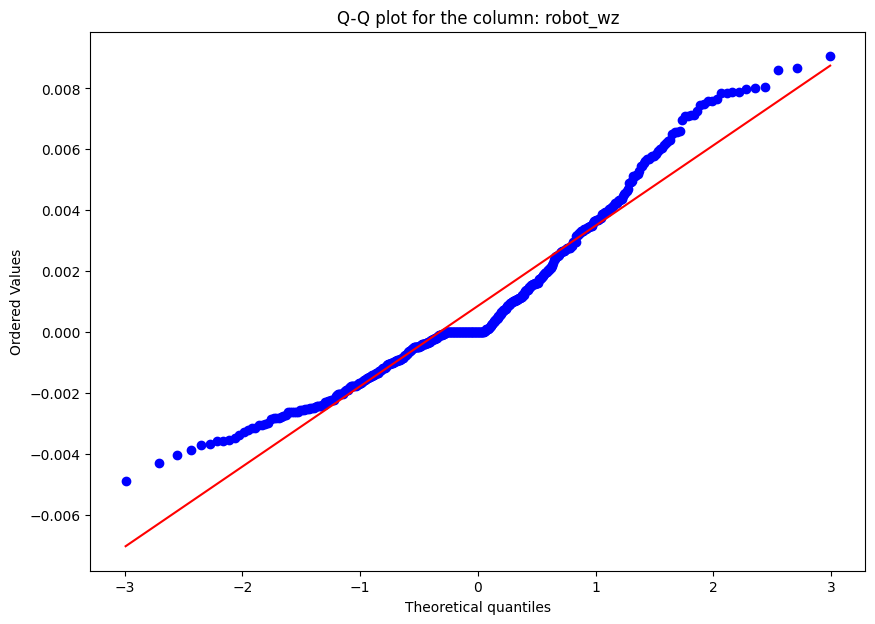

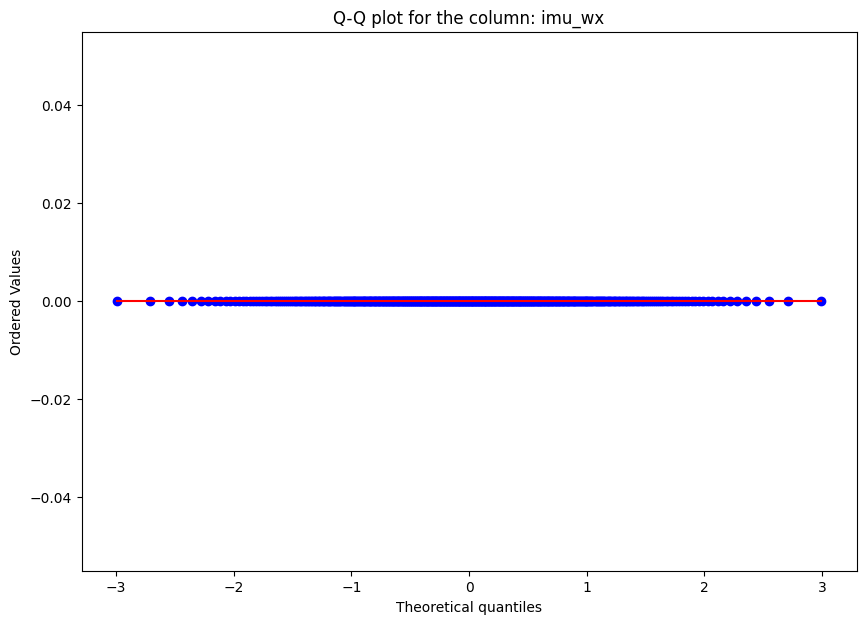

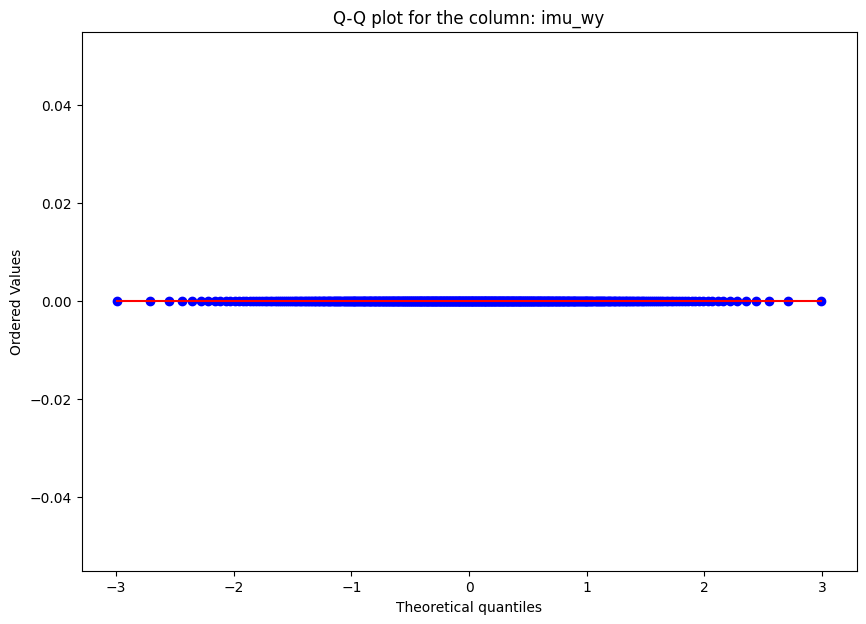

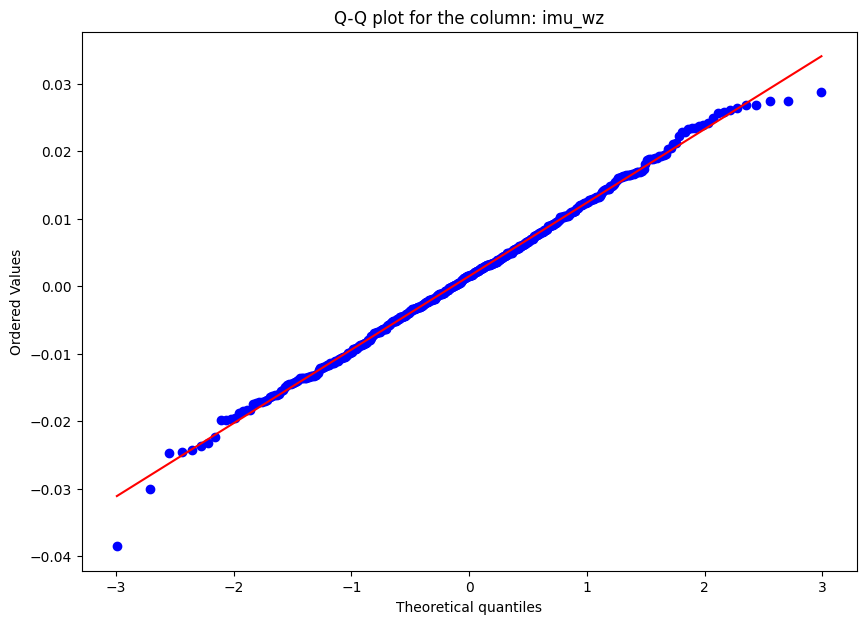

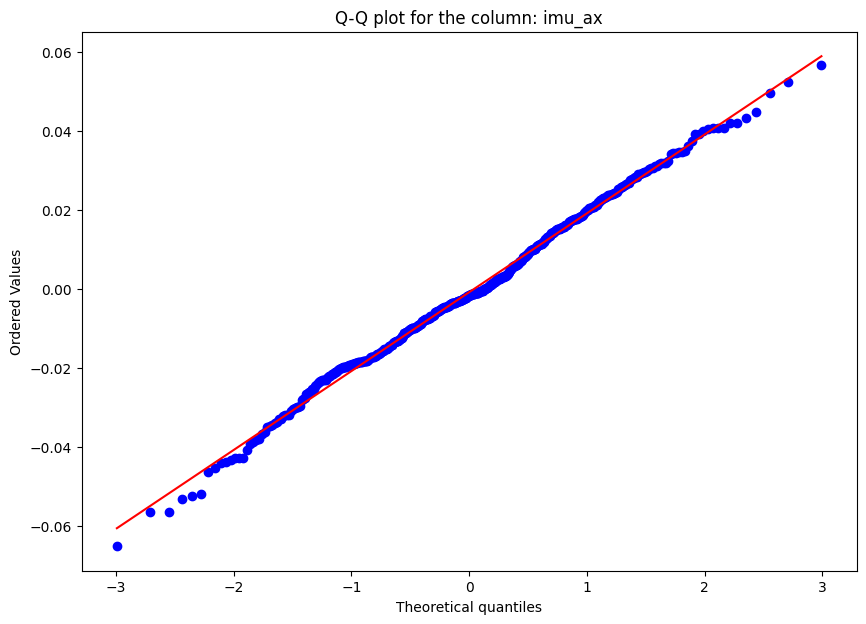

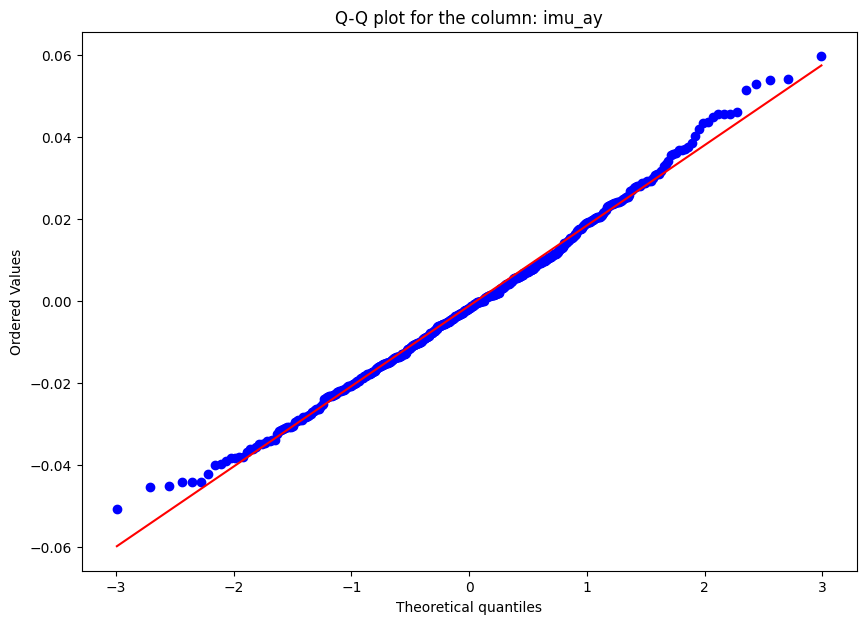

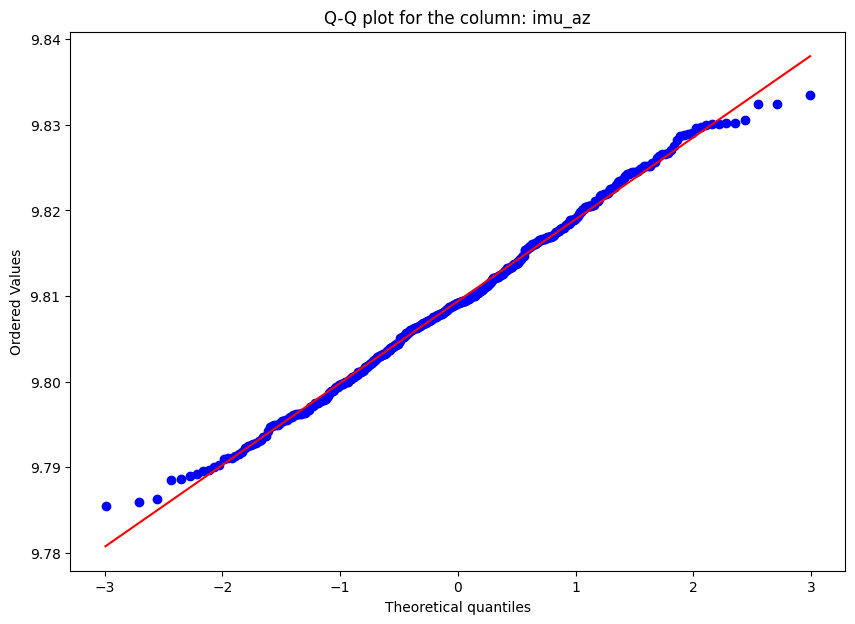

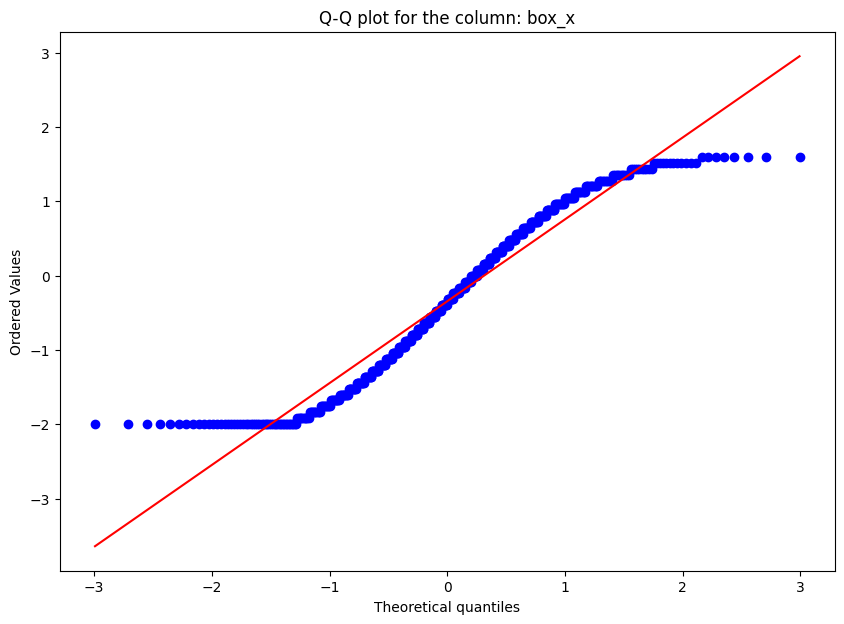

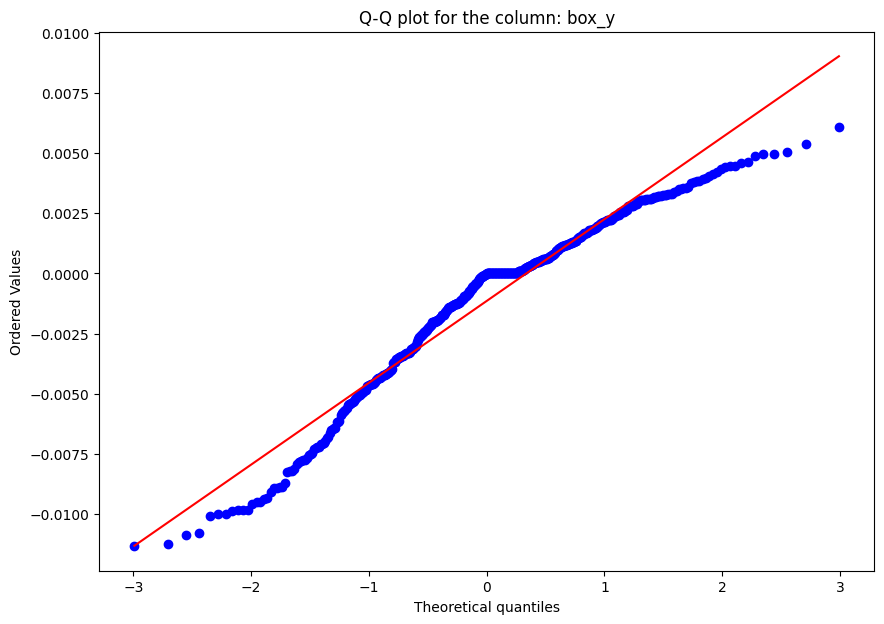

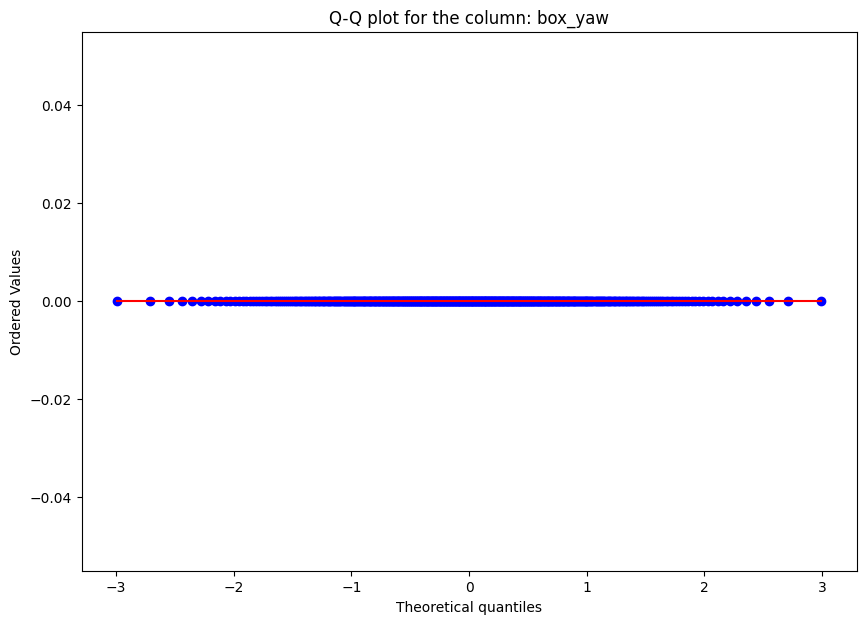

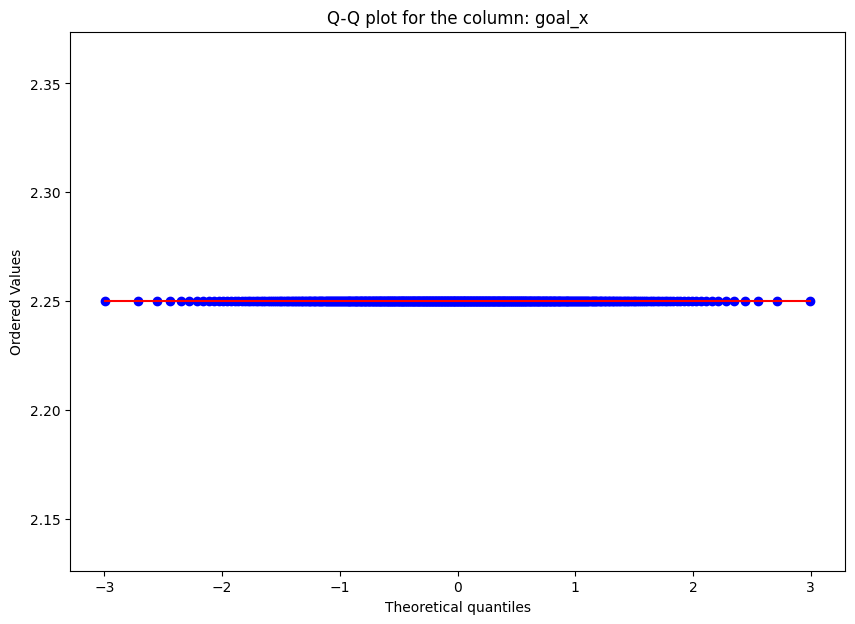

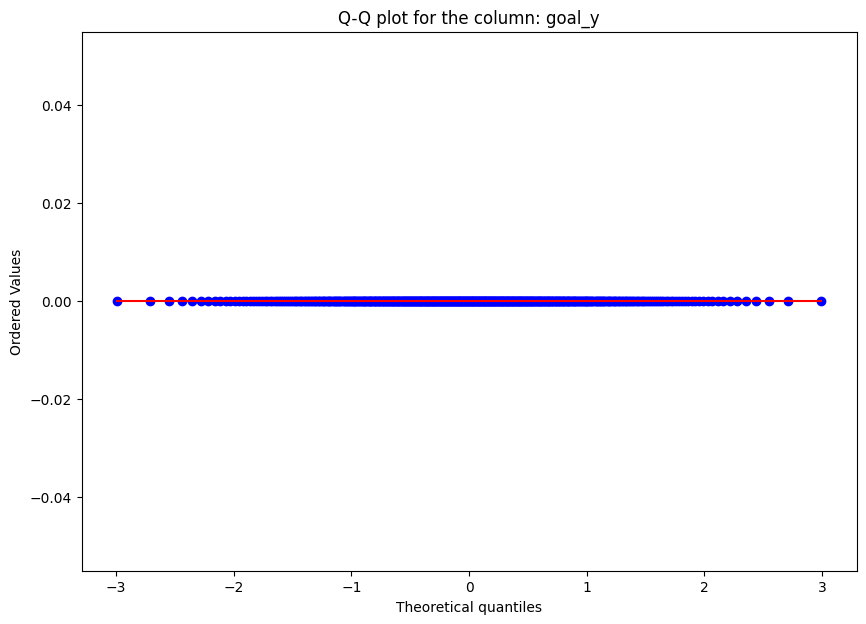

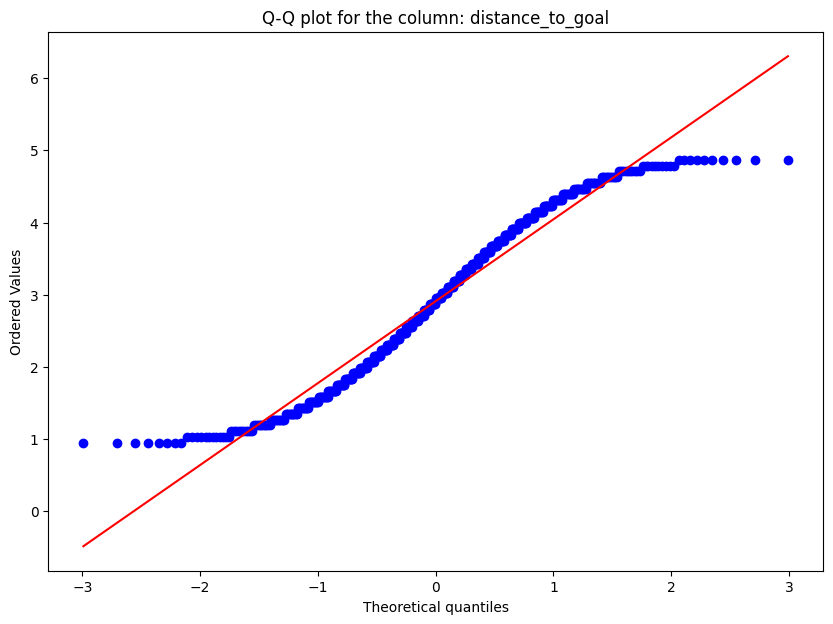

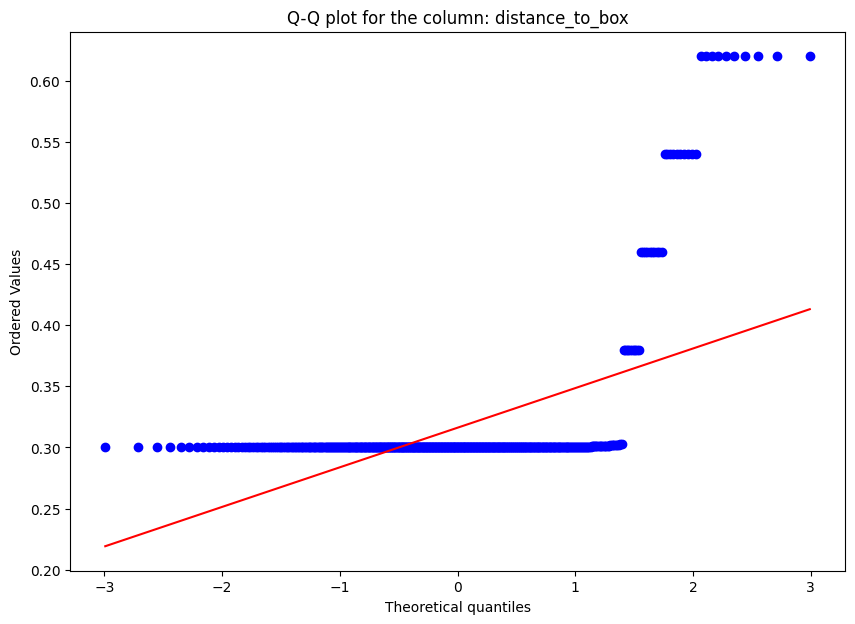

In [19]:
num_cols = state_df.select_dtypes(include=['number']).columns
num_cols = [c for c in num_cols if c not in ['contact_flag', 'in_goal']] # except for the "bool" variables

for col in num_cols:
    create_QQ_graph_for_each_column(state_df, col)

Observing the Q-Q graphs, we conclude that:

- `robot_x`
- `robot_y`
- `box_x`
- `box_y`
- `goal_x`
- `goal_y`
- `distance_to_goal`
- `distance_to_box`

Should benefit from **Min-Max Scalling**, as the plots show strong skewness. Since they represent positions or distances, we need to normalize them without distorting their natural range.

As for the following variables:

- `robot_vx`
- `robot_vy`
- `robot_wz`
- `imu_wx`
- `imu_wy`
- `imu_wz`
- `imu_ax`
- `imu_ay`
- `imu_az`
- `robot_yaw`
- `box_yaw`

The plots look centered around zero, roughly symmetrical, or oscillating both positive and negative. **Standardization** will stabilize gradients and preserve 0 as the neutral value, which is ideal for control-oriented variables in A2C/PPO training.

In [20]:
# Define the feature groups

# Min–Max 
minmax_cols = [
    'robot_x','robot_y',
    'box_x','box_y',
    'goal_x','goal_y',
    'distance_to_goal','distance_to_box'
]

# Standardization
standardize_cols = [
    'robot_vx','robot_vy','robot_wz',
    'imu_wx','imu_wy','imu_wz',
    'imu_ax','imu_ay','imu_az',
    'robot_yaw','box_yaw'
]

# Keep only columns that actually exist (defensive)
minmax_cols = [c for c in minmax_cols if c in state_df.columns]
standardize_cols = [c for c in standardize_cols if c in state_df.columns]

# Apply scaling
std_scaler = StandardScaler().fit(state_df[standardize_cols])
state_df.loc[:, standardize_cols] = std_scaler.transform(state_df[standardize_cols])

mm_scaler = MinMaxScaler().fit(state_df[minmax_cols])
state_df.loc[:, minmax_cols] = mm_scaler.transform(state_df[minmax_cols])

state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_vy,robot_wz,imu_wx,imu_wy,imu_wz,imu_ax,...,imu_az,box_x,box_y,box_yaw,goal_x,goal_y,contact_flag,in_goal,distance_to_goal,distance_to_box
0,0.000000,0.277676,-0.249451,0.063372,0.0,-0.317606,0.0,0.0,-0.136923,0.342490,...,-0.869456,0.000000,0.649955,0.0,0.0,0.0,0,0,1.000000,1.000000
1,0.020408,0.277676,-0.249451,0.063372,0.0,-0.317606,0.0,0.0,-0.556797,-0.956307,...,1.469053,0.000000,0.649955,0.0,0.0,0.0,0,0,0.979592,0.750000
2,0.040816,0.277676,-0.249451,0.063372,0.0,-0.317606,0.0,0.0,-0.591366,-0.582718,...,0.438251,0.000000,0.649955,0.0,0.0,0.0,0,0,0.959184,0.500000
3,0.061225,0.277676,-0.249451,0.063372,0.0,-0.317606,0.0,0.0,-0.040972,-0.894730,...,0.793005,0.000000,0.649955,0.0,0.0,0.0,0,0,0.938775,0.250000
4,0.081633,0.277676,-0.249451,0.063372,0.0,-0.317606,0.0,0.0,-1.376045,-0.418798,...,-1.287662,0.000000,0.649955,0.0,0.0,0.0,0,0,0.918367,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.918366,0.091261,-0.771134,0.063372,0.0,0.662311,0.0,0.0,0.604986,2.539694,...,0.417130,0.911111,0.416228,0.0,0.0,0.0,1,0,0.081638,0.000098
496,0.938774,0.085845,-0.708211,0.063372,0.0,0.890569,0.0,0.0,-2.201687,0.166468,...,1.515673,0.933333,0.437889,0.0,0.0,0.0,1,0,0.061230,0.000122
497,0.959182,0.081082,-0.651118,0.063372,0.0,0.778596,0.0,0.0,-0.581934,-0.178124,...,-0.522804,0.955556,0.423311,0.0,0.0,0.0,1,0,0.040823,0.000120
498,0.979590,0.076911,-0.590101,0.063372,0.0,0.853954,0.0,0.0,-1.094277,-0.184922,...,2.128376,0.977778,0.420288,0.0,0.0,0.0,1,0,0.020416,0.000125


In [21]:
# Let's do a small check:

state_df.describe().T

,count,mean,std,min,25%,50%,75%,max
robot_x,500.0,4.999168e-01,0.294664,0.000000,0.244898,0.500000,0.755102,1.000000
robot_y,500.0,3.059668e-01,0.148488,0.000000,0.260199,0.277676,0.307252,1.000000
robot_yaw,500.0,5.684342e-17,1.001002,-1.392792,-0.628300,-0.249451,0.364675,3.932049
robot_vx,500.0,-3.552714e-16,1.001002,-15.779734,0.063372,0.063372,0.063372,0.063372
robot_vy,500.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
robot_wz,500.0,-2.842171e-17,1.001002,-2.127042,-0.654203,-0.317606,0.610138,3.042114
imu_wx,500.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
imu_wy,500.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
imu_wz,500.0,5.684342e-17,1.001002,-3.688081,-0.658459,0.003373,0.681142,2.515875
imu_ax,500.0,-1.421085e-17,1.001002,-3.230818,-0.684330,-0.043415,0.708608,2.889123


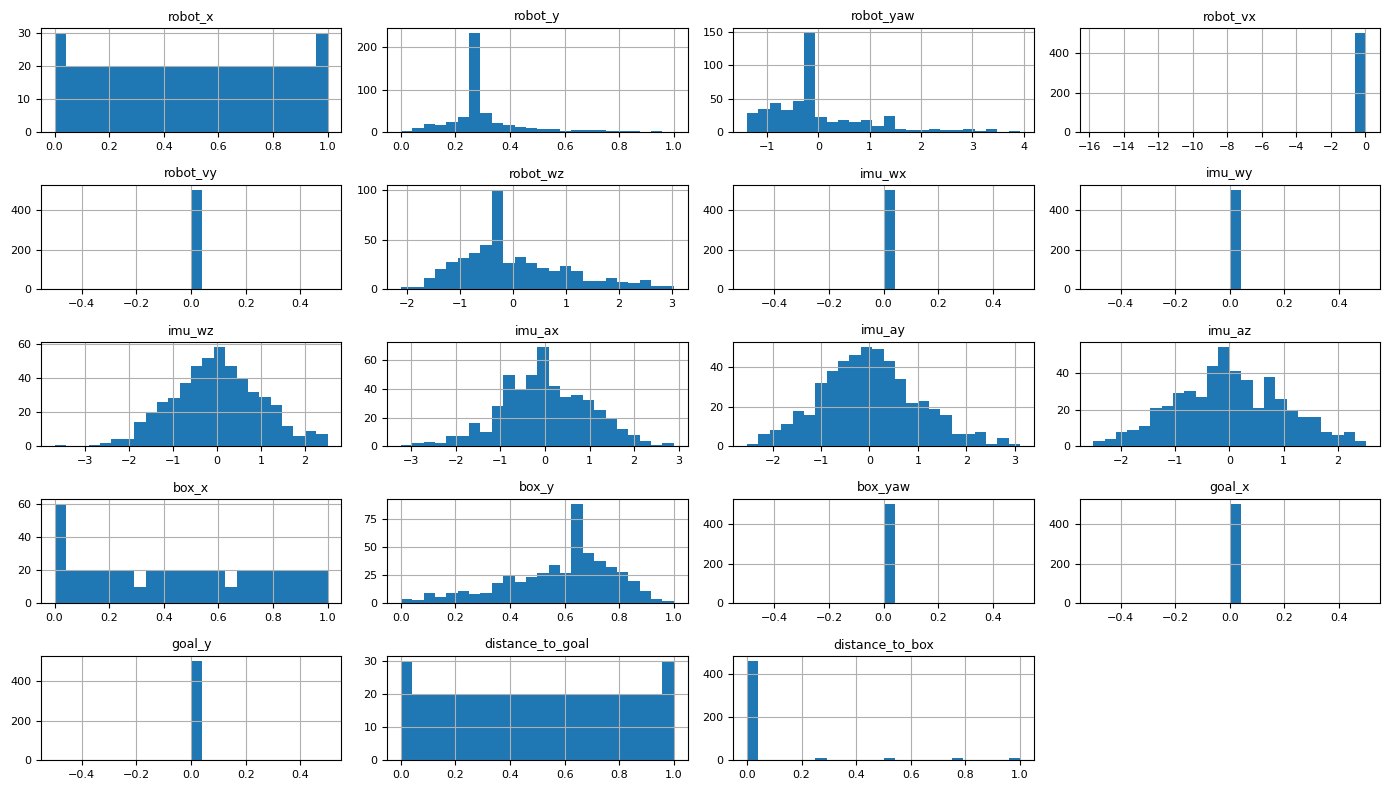

In [22]:
hist_grid(state_df, ncols=4, bins=24, figsize=(14,8))

For the Standardized columns, we see they have **mean ≈ 0** and **std ≈ 1**, because of the transformation, which measures each value's distance from the average, expressed in units of standard deviation.

For the Min-Max columns, we see they have **min ≈ 0** and **max ≈ 1**, as we are recalibrating the coordinate system of each variable, mapping the smallest value to 0 and the largest to 1.

## Action DataFrame

### Scaling

Since we don't have any object variables, to determine the most appropriate scaling strategy for each continuous variable, Q-Q (quantile-quantile) plots will be generated.

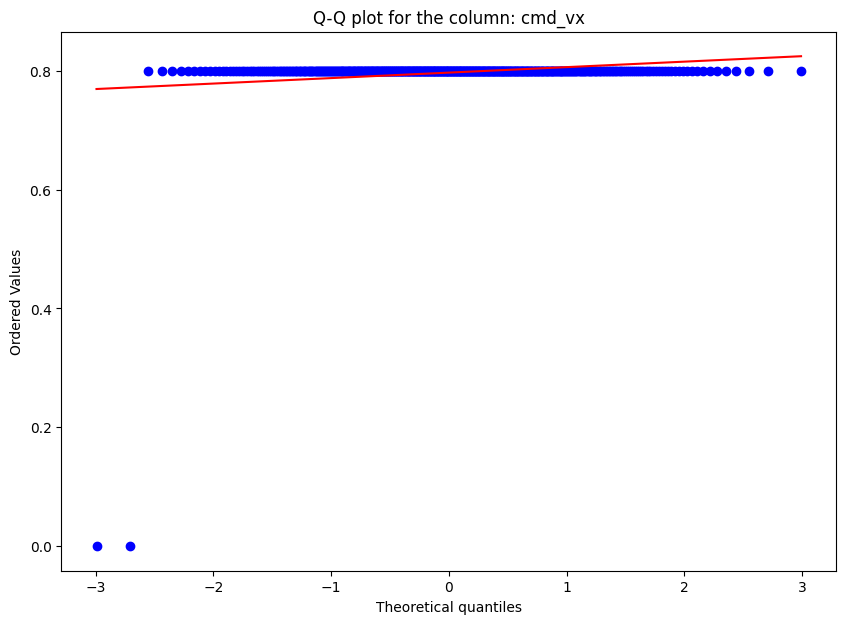

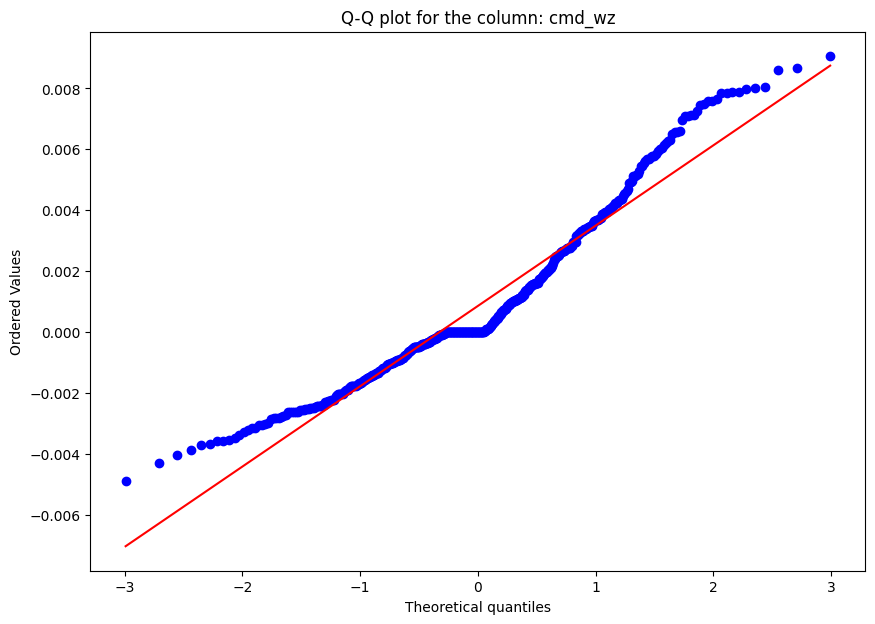

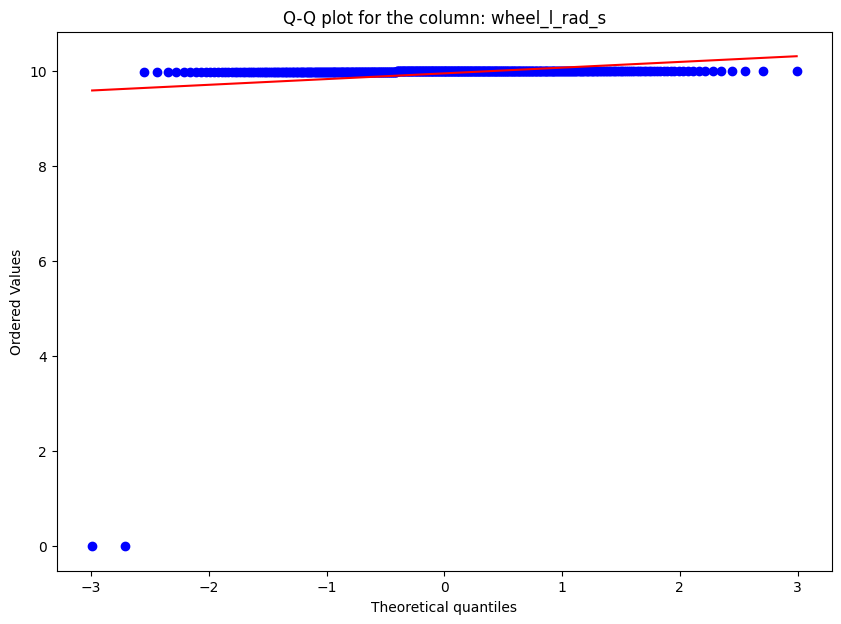

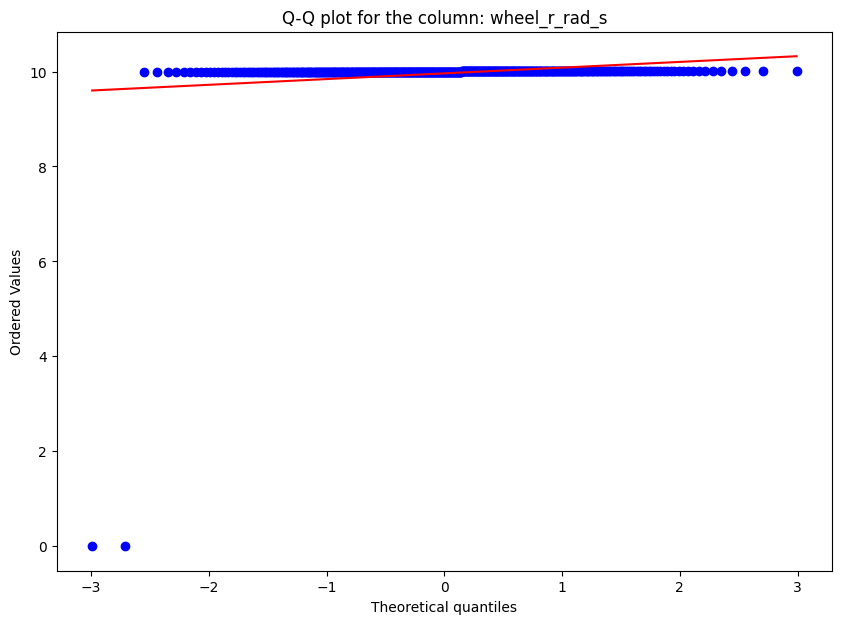

In [23]:
num_cols = action_df.select_dtypes(include=['number']).columns

for col in num_cols:
    create_QQ_graph_for_each_column(action_df, col)

The Q-Q plots of the action variables (`cmd_vx`, `cmd_wz`, `wheel_l_rad_s`, and `wheel_r_rad_s`) show that their distributions are approximately linear with respect to the theoretical quantiles, but with slight deviations and compression near the tails. 

- `cmd_vx` and the wheel angular speeds display near-constant plateaus with slight skewness.
- `cmd_wz` is roughly symmetric around zero, with a slight curvature at the extremes but still aligned along the diagonal.

The diagonals are not heavily skewed, but have different dynamic ranges and magnitudes. Since they represent **continuous control signals**, preserving their relative variation while centering them around zero is essential. Therefore, **standardization** will be applied to these features to normalize their scale without distorting their physical meaning, with the goal of improving training stability.

In [24]:
# Standardization
standardize_cols = [
    'cmd_vx', 'cmd_wz', 'wheel_l_rad_s', 'wheel_r_rad_s'
]

# Keep only columns that actually exist (defensive)
standardize_cols = [c for c in standardize_cols if c in action_df.columns]

# Apply scaling
std_scaler = StandardScaler().fit(action_df[standardize_cols])
action_df.loc[:, standardize_cols] = std_scaler.transform(action_df[standardize_cols])

action_df

,cmd_vx,cmd_wz,wheel_l_rad_s,wheel_r_rad_s
0,0.063372,-0.317606,0.066180,0.060561
1,0.063372,-0.317606,0.066180,0.060561
2,0.063372,-0.317606,0.066180,0.060561
3,0.063372,-0.317606,0.066180,0.060561
4,0.063372,-0.317606,0.066180,0.060561
...,...,...,...,...
495,0.063372,0.662311,0.057545,0.069193
496,0.063372,0.890569,0.055534,0.071203
497,0.063372,0.778596,0.056520,0.070217
498,0.063372,0.853954,0.055856,0.070881


In [25]:
# Let's do a small check:

action_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cmd_vx,500.0,-3.552714e-16,1.001002,-15.779734,0.063372,0.063372,0.063372,0.063372
cmd_wz,500.0,-2.842171e-17,1.001002,-2.127042,-0.654203,-0.317606,0.610138,3.042114
wheel_l_rad_s,500.0,-5.702105e-16,1.001002,-15.779121,0.057931,0.066180,0.069146,0.082124
wheel_r_rad_s,500.0,6.821210e-16,1.001002,-15.779122,0.057504,0.060561,0.068733,0.090156


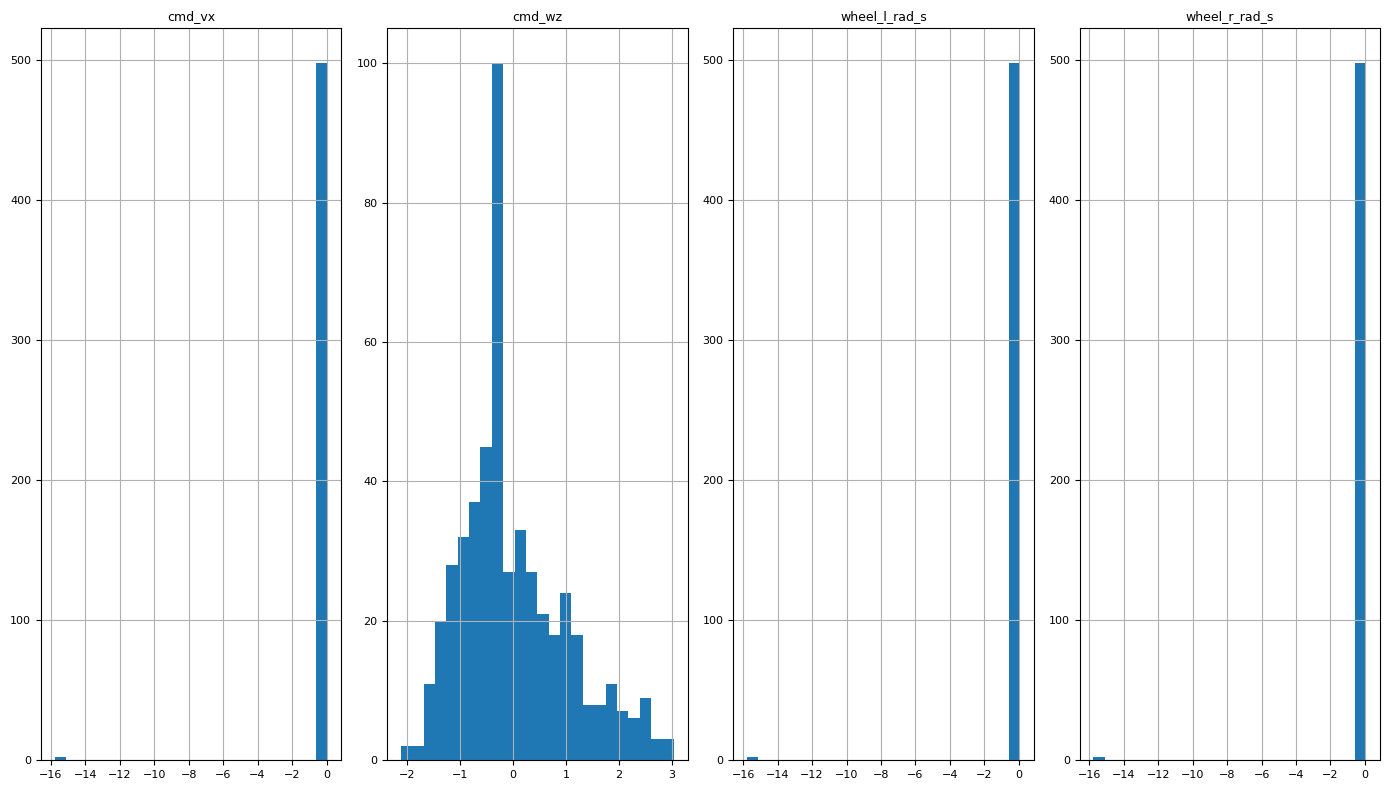

In [26]:
hist_grid(action_df, ncols=4, bins=24, figsize=(14,8))

Since we applied Standardization to all the columns, we see that all of them have **mean ≈ 0** and **std ≈ 1**.

## Transformation Description

We already did the following:

- Split the dataframe into state, action, and reward.
- `state_df` had two enhanced derived features, 2 variables encoded, standardization, and min-max transformation.
- `action_df` had a standardization transformation.
- `reward_df` remained untouched.

Since our model relies on Reinforcement Learning, the next steps to take will be to do **feature extraction** on the `state_df`. Since the action space is part of the environment specification, we shouldn't be dropping or transforming action dimensions beyond numeric scaling for stability. In that sense, as the state space is the observation space, we can reduce redundancy and stabilize learning.

## Feature Selection/Extraction

### Variance Thresholding

In [27]:
# Numeric-only view (skip categorical flags if present)
state_num = state_df.select_dtypes(include=['number']).copy()

vt = VarianceThreshold(threshold=1e-6)
vt.fit(state_num)

low_var_cols = state_num.columns[~vt.get_support()]
print("Near-constant features (candidates to drop):", list(low_var_cols))

Near-constant features (candidates to drop): ['robot_vy', 'imu_wx', 'imu_wy', 'box_yaw', 'goal_x', 'goal_y']


Even though RL doesn't have a target variable, the **state representation** acts as the input to the policy and value networks. Applying **variance thresholding** is useful to remove state variables that barely change during simulation, because:

1. They carry almost no information for decision-making.
2. They introduce unnecessary noise.
3. They slow down learning and reduce sample efficiency.

Since variance thresholding is a filtering method for representation efficiency, this helps us to reduce model complexity and training time.

The selected candidates are:

- `robot_vy`: lateral velocity of the robot. This value is likely near zero because the robot moves mostly on the x-axis.
- `imu_wx` and `imu_wy`: angular velocity around x/y. The robot rotates around the z-axis.
- `bow_yaw`: box orientation. The robot might not rotate significantly during the push (but this could change with multi-agent in later simulations).
- `goal_x` and `goal_y`: goal coordinates. The target position is fixed, so it does not add any learning signal.

We will drop: `robot_vy`, `imu_wx`, `imu_wy`, `goal_x`, and `goal_y`.

In [28]:
state_df.drop(columns=list(low_var_cols), inplace=True, errors='ignore')
state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_wz,imu_wz,imu_ax,imu_ay,imu_az,box_x,box_y,contact_flag,in_goal,distance_to_goal,distance_to_box
0,0.000000,0.277676,-0.249451,0.063372,-0.317606,-0.136923,0.342490,-0.222490,-0.869456,0.000000,0.649955,0,0,1.000000,1.000000
1,0.020408,0.277676,-0.249451,0.063372,-0.317606,-0.556797,-0.956307,0.119457,1.469053,0.000000,0.649955,0,0,0.979592,0.750000
2,0.040816,0.277676,-0.249451,0.063372,-0.317606,-0.591366,-0.582718,0.559008,0.438251,0.000000,0.649955,0,0,0.959184,0.500000
3,0.061225,0.277676,-0.249451,0.063372,-0.317606,-0.040972,-0.894730,0.028011,0.793005,0.000000,0.649955,0,0,0.938775,0.250000
4,0.081633,0.277676,-0.249451,0.063372,-0.317606,-1.376045,-0.418798,-1.886884,-1.287662,0.000000,0.649955,0,0,0.918367,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.918366,0.091261,-0.771134,0.063372,0.662311,0.604986,2.539694,-0.251463,0.417130,0.911111,0.416228,1,0,0.081638,0.000098
496,0.938774,0.085845,-0.708211,0.063372,0.890569,-2.201687,0.166468,-0.664785,1.515673,0.933333,0.437889,1,0,0.061230,0.000122
497,0.959182,0.081082,-0.651118,0.063372,0.778596,-0.581934,-0.178124,0.228314,-0.522804,0.955556,0.423311,1,0,0.040823,0.000120
498,0.979590,0.076911,-0.590101,0.063372,0.853954,-1.094277,-0.184922,0.851393,2.128376,0.977778,0.420288,1,0,0.020416,0.000125


### Correlation Filtering

In [29]:
state_num = state_df.select_dtypes(include=['number']).copy()
corr = state_num.corr().abs()

# Upper triangle mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Threshold of 0.90
to_drop = [col for col in upper.columns if any(upper[col] >= 0.90)]
print("Highly correlated features (candidates):", to_drop)

Highly correlated features (candidates): ['robot_yaw', 'box_x', 'box_y', 'distance_to_goal']


Since the state representation directly affects how well the agent perceives the environment, we need to make sure we don't have features highly correlated, because they could provide **redundant information** to the agent. This redundancy could lead to unstable learning, slower convergence, and reduced generalization.

The selected candidates are:

- `robot_yaw`: measures orientation rate/angle. 
- `box_x` and `box_y`: correlated with `distance_to_box`. Since we already included it, absolute positions are redundant in this fixed map.
- `distance_to_goal`: correlated with `goal_x` and `goal_y`. Since these columns were dropped, we should keep this information so the policy still has goal-related information in the state.

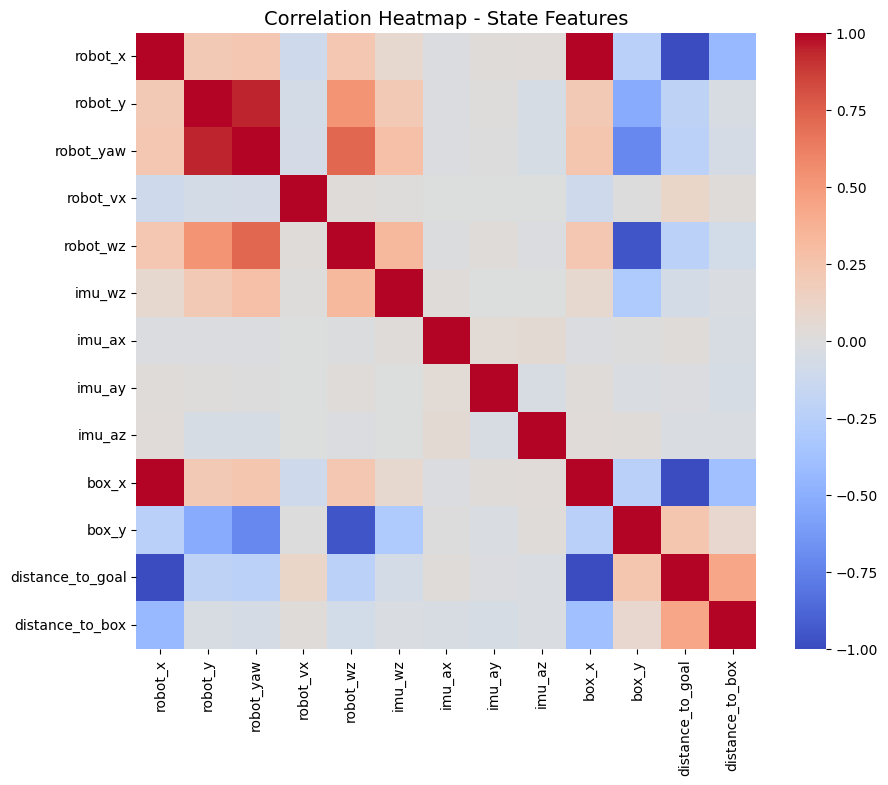

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(state_num.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title("Correlation Heatmap - State Features", fontsize=14)
plt.show()

In [31]:
# After confirming this information with the Heatmap, we'll proceed to remove the
# columns as suggested:

cols_to_drop = ['box_x', 'box_y']
state_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
state_df

,robot_x,robot_y,robot_yaw,robot_vx,robot_wz,imu_wz,imu_ax,imu_ay,imu_az,contact_flag,in_goal,distance_to_goal,distance_to_box
0,0.000000,0.277676,-0.249451,0.063372,-0.317606,-0.136923,0.342490,-0.222490,-0.869456,0,0,1.000000,1.000000
1,0.020408,0.277676,-0.249451,0.063372,-0.317606,-0.556797,-0.956307,0.119457,1.469053,0,0,0.979592,0.750000
2,0.040816,0.277676,-0.249451,0.063372,-0.317606,-0.591366,-0.582718,0.559008,0.438251,0,0,0.959184,0.500000
3,0.061225,0.277676,-0.249451,0.063372,-0.317606,-0.040972,-0.894730,0.028011,0.793005,0,0,0.938775,0.250000
4,0.081633,0.277676,-0.249451,0.063372,-0.317606,-1.376045,-0.418798,-1.886884,-1.287662,0,0,0.918367,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.918366,0.091261,-0.771134,0.063372,0.662311,0.604986,2.539694,-0.251463,0.417130,1,0,0.081638,0.000098
496,0.938774,0.085845,-0.708211,0.063372,0.890569,-2.201687,0.166468,-0.664785,1.515673,1,0,0.061230,0.000122
497,0.959182,0.081082,-0.651118,0.063372,0.778596,-0.581934,-0.178124,0.228314,-0.522804,1,0,0.040823,0.000120
498,0.979590,0.076911,-0.590101,0.063372,0.853954,-1.094277,-0.184922,0.851393,2.128376,1,0,0.020416,0.000125


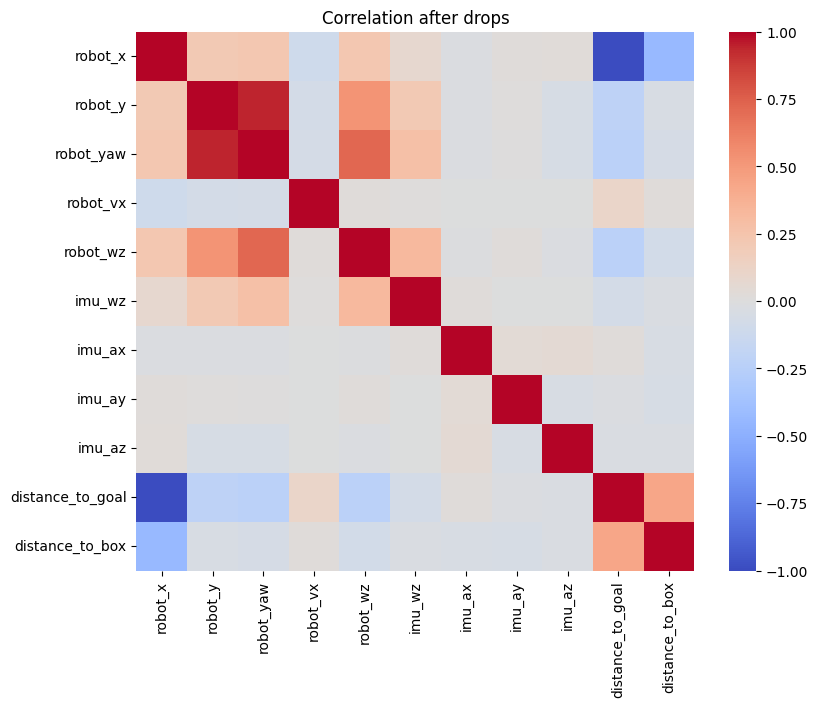

In [32]:
num = state_df.select_dtypes(include=['number'])
plt.figure(figsize=(9,7))
sns.heatmap(num.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation after drops")
plt.show()

### Next-State Predictiveness (self-supervised)

In [33]:
# Applying this to rank the features by how well they explain the
# next-state change:

num_cols = state_df.select_dtypes(include=['number']).columns.tolist()
# Predict delta for a subset we care about (e.g., pose+vel)
target_cols = [c for c in num_cols if c not in ['contact_flag','in_goal']]

X = state_df[num_cols].iloc[:-1].values
Y = (state_df[target_cols].iloc[1:].values - state_df[target_cols].iloc[:-1].values)

sc = StandardScaler().fit(X); Xz = sc.transform(X)
model = RidgeCV(alphas=(1e-3,1e-2,1e-1,1,10)).fit(Xz, Y)

imp = np.linalg.norm(model.coef_, axis=0)  # L2 across targets
rank = pd.Series(imp, index=num_cols).sort_values(ascending=False)

print("Top features explaining next-state change:\n", rank.head(10))
print("Lowest features:\n", rank.tail(5))

Top features explaining next-state change:
 imu_wz             1.018368
robot_vx           1.013881
imu_az             1.003716
imu_ay             0.993713
imu_ax             0.946636
robot_wz           0.276470
robot_yaw          0.192017
robot_y            0.187665
distance_to_box    0.129373
robot_x            0.067125
dtype: float64
Lowest features:
 robot_yaw           0.192017
robot_y             0.187665
distance_to_box     0.129373
robot_x             0.067125
distance_to_goal    0.066900
dtype: float64


We see that:

- **Rank 1-5**: These are the variables with the core kinematic and dynamics that strongly determine the next state.
- **Rank 6-7**: Variables that could be redundant with IMU data, but still relevant for angular motion.
- **Rank 8-10**: Variables with spatial context. These are slower to change, less predictive of short-term state transitions, but still required for task awareness.

This self-supervised regression task confirms that inertial and motion variables dominate short-term dynamics, while positional and distance features contribute less to immediate transitions but remain essential for spatial awareness and goal-directed behavior. As a result, no further columns will be removed. The resulting **13-feature** state vector maintains a balance between dynamic observability and task awareness, which is ideal for RL training where both instantaneous control and spatial context influence the policy.

# Conclusion <a class="anchor" id="conclusion" ></a>

During this stage, the dataset was transformed into a structured, learning-ready representation, aligning with the **CRISP-ML** methodology. Since we are dealing with a Reinforcement Learning problem, we don't have a single target variable. Instead, the data was organized into:

- state,
- action,
- reward.

Which together describes the agent's experience within the environment.

## Feature Engineering and Transformation:

1. Two derived features were introduced, capturing spatial relationships crucial for task awareness.
2. Binary features were encoded as 0/1 categorical variables to simplify their use by the learning algorithm.
3. Scaling methods such as Standardization and Min-Max scaling were applied to maintain numerical consistency, ensuring stable gradients and preventing feature dominance during training.

## Filtering and Feature Selection:

Two unsupervised filtering methods were applied to refine the state space:

1. **Variance Thresholding**: Removed near-constant variables that carried little to no information for decision-making.
2. **Correlation Filtering**: Identified and removed redundant features highly correlated with relational distances, improving representational efficiency.

The state representation was reduced from 20 to **13 variables**. Filtering the variables simplifies the state representation while maintaining full observability.

## Final Structure:

- **State**: 13 optimized features integrating motion, perception, and task awareness.
- **Action**: 4 continuous, standardized control variables.
- **Reward**: Unscaled, preserving raw reward magnitudes used by the policy for optimization.

This preparation ensures that the modeling phase can proceed with a clean, balanced, and meaningful feature set, supporting faster convergence, reduced training noise, and improved policy stability. The process followed the CRISP-ML iterative framework, combining domain knowledge, quantitative evaluation, and methodological justification at every step.

# References <a class="anchor" id="references" ></a>

[1] Tsinghua University, “History,” Tsinghua University. https://www.tsinghua.edu.cn/en/About/History.htm 

[2]Tsinghua University, “School of Vehicle and Mobility,” THU - Graduate Admissions. https://yz.tsinghua.edu.cn/en/info/1014/1115.htm 

[3] Instituto Nacional de Estadística y Geografía (INEGI), “Sistema de Clasificación Industrial de América del Norte, México SCIAN 2023,” INEGI, Jul. 28, 2023. https://www.inegi.org.mx/scian/ 

[4] Open Robotics, “Features and Benefits of GAZEBO SIM,” Gazebo. https://gazebosim.org/home 

[5] Open Robotics, “Getting started with ROS 2,” ROS 2 Documentation: Rolling Documentation. https://docs.ros.org/en/rolling/index.html 

[6] D. Ge and H. Ji, “Efficient Training in Multi-Agent Reinforcement Learning: A Communication-Free Framework for the Box-Pushing problem,” arXiv.org, Nov. 19, 2024. https://arxiv.org/abs/2411.12246 

[7] K. Kondo, C. T. Tewari, A. Tagliabue, J. Tordesillas, P. C. Lusk, and J. P. How, “PRIMER: Perception-Aware robust learning-based multiagent trajectory Planner,” arXiv (Cornell University), Jun. 2024, doi: 10.13140/rg.2.2.14435.57124. 

[8] H. Farivarnejad and S. Berman, “Multirobot control Strategies for collective transport,” Annual Review of Control Robotics and Autonomous Systems, vol. 5, no. 1, pp. 205–219, Nov. 2021, doi: 10.1146/annurev-control-042920-095844. 

[9] E. Elelimy, D. Szepesvari, M. White, and M. Bowling, “Rethinking the foundations for continual reinforcement learning,” arXiv.org, Apr. 10, 2025. https://arxiv.org/abs/2504.08161 
[10] C. Pan et al., “A survey of Continual Reinforcement learning,” arXiv.org, Jun. 27, 2025. https://arxiv.org/abs/2506.21872 

[11] M. Rahimi, S. Gibb, Y. Shen, and H. M. La, “A comparison of various approaches to reinforcement learning algorithms for multi-robot box pushing,” arXiv.org, Sep. 21, 2018. https://arxiv.org/abs/1809.08337 

[12] K. Javed and R. S. Sutton, “The Big World Hypothesis and its Ramifications for Artificial Intelligence,” OpenReview. https://openreview.net/forum?id=Sv7DazuCn8 

[13] S. Zhao, Mathematical foundations of reinforcement learning. 2025. doi: 10.1007/978-981-97-3944-8. 

[14] R. S. Sutton and A. G. Barto, Reinforcement learning: An Introduction. MIT Press, 1998. 

[15] S. E. Li, Reinforcement learning for sequential decision and optimal control. 2023. doi: 10.1007/978-981-19-7784-8. 

[16] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, “Proximal Policy optimization Algorithms,” arXiv.org, Jul. 20, 2017. https://arxiv.org/abs/1707.06347